In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:

import numpy as np
import re
import os
from pathlib import Path
import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from fastai.conv_learner import *
from fastai.dataset import *

In [5]:
PATH = Path(r'C:\Users\PaballoM\Documents\Deep Learning Datasets\InclineFaceDectection')

In [6]:
anno_path = PATH/'ImageAnnotations'

In [7]:
json_annotations = [pth for pth in anno_path.iterdir()
            if pth.suffix == '.json']

In [8]:
json.load(json_annotations[4700].open())['imagePath']

'frame_5983.png'

In [9]:
def get_bb_hght_wdth(co_ords):
    return np.array([co_ords[0][0],co_ords[0][1],
                     np.abs(co_ords[0][0]-co_ords[1][0]+1),
                     np.abs(co_ords[1][1]-co_ords[2][1]+1)])

Get top left and bottom right co ordinates

In [10]:
#def get_topleft_bttmright(co_ords):
#    return np.array([co_ords[0][0],co_ords[0][1],co_ords[2][0],co_ords[2][1]])


Create a category to id dict

In [11]:
cat2id_dict = {}
id_counter = 0

# I know before hand that there are 22 distinct classes
while id_counter <=22:
    
    for json_file in json_annotations:
        img_json = json.load(json_file.open())
        for shape_dict in img_json['shapes']:
            if shape_dict['label'] in cat2id_dict:
                pass
            else:
                cat2id_dict[shape_dict['label']] = id_counter
                id_counter +=1

In [12]:
cat2id_dict

{'imraan': 0,
 'person': 1,
 'ryan': 2,
 'alwyn': 3,
 'empty': 4,
 'imaraan': 5,
 'yacoob': 6,
 'head': 7,
 'face': 8,
 'buhle': 9,
 'amna': 10,
 'siphiwo': 11,
 'tiff': 12,
 'maq': 13,
 'james': 14,
 'jan': 15,
 'ben': 16,
 'dennis': 17,
 'sino': 18,
 'paul': 19,
 'mike': 20,
 'nassief': 21,
 'stubbe': 22}

In [13]:
id2cat = {}
for key_val,val in cat2id_dict.items():
    id2cat[val] = key_val

id2cat

{0: 'imraan',
 1: 'person',
 2: 'ryan',
 3: 'alwyn',
 4: 'empty',
 5: 'imaraan',
 6: 'yacoob',
 7: 'head',
 8: 'face',
 9: 'buhle',
 10: 'amna',
 11: 'siphiwo',
 12: 'tiff',
 13: 'maq',
 14: 'james',
 15: 'jan',
 16: 'ben',
 17: 'dennis',
 18: 'sino',
 19: 'paul',
 20: 'mike',
 21: 'nassief',
 22: 'stubbe'}

A bounding box is defined as the TOP LEFT CORNER CO-ORDINATES and the BOTTOM RIGHT CORNER CO-ORDINATES instead of of the including one corner and height and width. I.e. if (x_0,y_0) represents the TOP LEFT corner co-ordinates then the boudning box co-ordinates are [y_0,x_0,y_2,x_2]

In [16]:
def get_topleft_bttmright(co_ords):
    return np.array([co_ords[0][1],co_ords[0][0],co_ords[2][1],co_ords[2][0]])

In [17]:
def get_trn_anno():
    try:
        
        trn_anno = collections.defaultdict(lambda:[])
        for json_file in json_annotations:
            
            img_json = json.load(json_file.open())
            img_name = os.path.basename(img_json['imagePath'])
            write_name = re.sub('png', 'jpg', img_name)
            
            for shape_dict in img_json['shapes']:
                
                if shape_dict['label'] not in ['person','tiff','stubbe','head','face',
                                              'nassief','dennis']:
                    
                    co_ords = shape_dict['points']
                    label = shape_dict['label']
                    bndbox = get_topleft_bttmright(co_ords)
                    img_indx = int(re.findall(r'\d+',write_name)[0])
                    trn_anno[img_indx].append((bndbox,cat2id_dict[label]))
              
    except (ValueError,IndexError) as error:
        pass
    return trn_anno

trn_anno = get_trn_anno()

In [18]:
int(re.findall(r'\d+', 'frame_1007.png')[0])

1007

In [19]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)


def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [20]:
trn_anno[1007]

[(array([275,  54, 484, 231]), 0)]

The bb_hw function takes in an array of form(x_1,y_1,x_2,y_2) where x_1,y_1 are the top left hand corner co ordinates and x_2,y_2 are the bottom right hand co ordinates of an bounding box and returns (y_1,x_1,height_of_box,width_of_box)

In [21]:
def bb_hw(a):
    #""""
    #takes in co-ordinates of the form (y_0,x_0,y_2,x_2) and returns (y_0,x_0,HEIGHT,WIDTH)
    #""""
    return np.array([a[1],a[0],np.abs(a[3]-a[1]-1),np.abs(a[2]-a[0]-1)])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    img_name = 'frame_'+str(i)+'.jpg'
    im = open_image(IMG_PATH/img_name)
    draw_im(im, im_a)

In [22]:
x=json.load(json_annotations[1].open())['shapes']
x

[{'label': 'imraan',
  'line_color': None,
  'fill_color': None,
  'points': [[108, 327], [285, 327], [285, 474], [108, 474]]},
 {'label': 'person',
  'line_color': None,
  'fill_color': None,
  'points': [[105, 285], [1061, 285], [1061, 631], [105, 631]]}]

In [23]:
multi_class_file = PATH/'tmp/mc.csv'

In [24]:
trn_anno[2150]

[(array([268, 318, 376, 458]), 15), (array([453, 496, 576, 669]), 3)]

In [25]:

objects_in_img = collections.defaultdict(lambda:[])
for json_file in json_annotations:
            
    img_json = json.load(json_file.open())
    img_name = os.path.basename(img_json['imagePath'])
    write_name = re.sub('png', 'jpg', img_name)
    
    for shape_dict in img_json['shapes']:
        
        if shape_dict['label'] not in ['person','tiff','stubbe','head','face',
                                              'nassief','dennis']:
            label = shape_dict['label']
            objects_in_img[write_name].append(label)

In [26]:
objects_in_img['frame_1074.jpg']

['alwyn', 'imraan']

In [27]:
img_objects_list = []
for img in objects_in_img.keys():
    
    img_objects_list .append([img,[' '.join(str(person) for person in objects_in_img[img])]])
        

In [28]:
img_objects_list_str = [(x[0],x[1][0]) for x in img_objects_list]

In [29]:
df = pd.DataFrame(img_objects_list_str)
df.columns = ['file_name','class']
df.head(10)
#df.to_csv(r'C:\Users\PaballoM\Documents\Deep Learning Datasets\InclineFaceDectection\tmp\multi_class_labels.csv', index=False)

file_name   class
0   frame_1007.jpg  imraan
1   frame_1008.jpg  imraan
2   frame_1009.jpg  imraan
3   frame_1010.jpg  imraan
4   frame_1011.jpg  imraan
5  frame_10116.jpg    ryan
6  frame_10118.jpg    ryan
7   frame_1012.jpg  imraan
8  frame_10120.jpg    ryan
9  frame_10122.jpg    ryan

In [30]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/multi_class_bndbox.csv'

f_model=resnet34
sz=224
bs=9

In [31]:
 multi_class_int_id = np.array([np.array([cat2id_dict[person_list] for person_list in img[1][0].split()]) for img in img_objects_list])
multi_class_int_id
#cat2id_dict

array([array([0]), array([0]), array([0]), ..., array([0]), array([0]), array([0])], dtype=object)

In [ ]:
#[[person_list for person_list in img[1][0].split()] for img in img_objects_list]

In [32]:
df.shape

(5554, 2)

In [33]:
val_idxs = get_cv_idxs(df.shape[0])
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, multi_class_int_id)

In [34]:
img_bnd_box = []
for key_val in trn_anno.keys():
    img_name = 'frame_'+str(key_val)+'.jpg' #frame_1007.png
    bnd_box_vals=['-'.join(str(p) for p in np.array([x[0] for x in trn_anno[key_val]]).flatten())]

    img_bnd_box.append([img_name,bnd_box_vals[0]])


In [35]:
filename_to_bndbox_df = pd.DataFrame(img_bnd_box)
filename_to_bndbox_df.columns = ['img_name','boundingbox_coords']
#filename_to_bndbox_df[filename_to_bndbox_df['img_name']=='frame_1057.jpg']
#filename_to_bndbox_df.to_csv(MBB_CSV,index=False)
filename_to_bndbox_df.head()

img_name boundingbox_coords
0  frame_1007.jpg     275-54-484-231
1  frame_1008.jpg    327-108-474-285
2  frame_1009.jpg    328-122-470-311
3  frame_1010.jpg    311-130-458-323
4  frame_1011.jpg    333-161-463-348

In [36]:
2+2

4

In [37]:
#aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
#            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
#            RandomFlip(tfm_y=TfmType.COORD)]
aug_tfms = None
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
#md = ImageClassifierData.from_csv(PATH, 'Images_jpg', MBB_CSV, tfms=None, bs=bs, continuous=True, num_workers=4)
md = ImageClassifierData.from_csv(PATH,'Images_jpg', MBB_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4,
                                 cat_sep_delimter='-')

In [38]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [39]:
len(cat2id_dict)

23

In [40]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [41]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [42]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

*The image*

*The Bounding box and category*

trn_dl stands for training_dataloader(jeremy I really wish you would use better naming conventions my G)

the training_dataloader is an iterator which returns a mini batch of size bs(batch_size).
trn_dl is called as next(iter(md.trn_dl)). This returns one mini_batch. trn_dl always returns x_data,y_data

In [43]:
x,y=to_np(next(iter(md.trn_dl)))
x=md.val_ds.ds.denorm(x)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


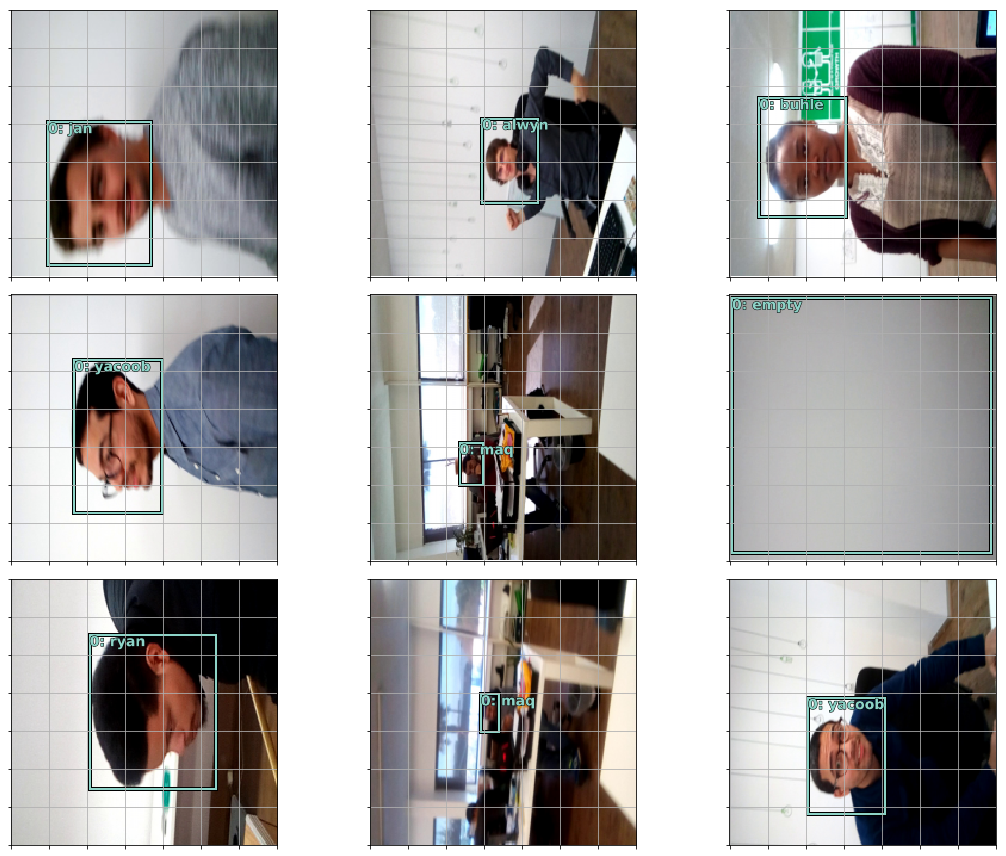

In [44]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

### Set up Model

We're going to make a simple first model that simply predicts what object is located in each cell of a 4x4 grid. Later on we can try to improve this.

In [45]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
        
    

In [46]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

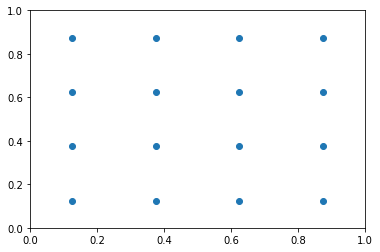

In [47]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [48]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.FloatTensor of size 16x4]

In [49]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [50]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.FloatTensor of size 16x4]

In [51]:
n_clas = len(id2cat)+1
n_act = k*(4+n_clas)

In [52]:
n_clas

24

In [53]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [54]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        # split into two conv layers 
        #one for regression(output=4 * k) and one for classfication(output= (len(id2cat)+1)) * k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        #return is flattened because loss expects a flat tensor, no other reason
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [55]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1

In [56]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [57]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [58]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    if to_np(torch.sum(bbox)==0)[0] ==1:
        print('temp fix')
        a,b,c,d= 0.0,0.1,0.11,0.2
        rand_array_1 = (b - a) * np.random.random(size=2) + a
        rand_array_2 = (d - c) * np.random.random(size=2) + c
        rand_array = np.concatenate((rand_array_1,rand_array_2))
        bbox = V(np.array([rand_array]))
    #print(bbox)
    #print('bbox[:,2] = '+ str(bbox[:,2]))
    #print('bbox[:,0] = '+ str(bbox[:,0]))
    #print('(bbox[:,2]-bbox[:,0]) = '+ str((bbox[:,2]-bbox[:,0])))
    #print('((bbox[:,2]-bbox[:,0])>0).nonzero() = '+ str(((bbox[:,2]-bbox[:,0])>0).nonzero()))
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [59]:
x,y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)

In [60]:
for i,o in enumerate(y): y[i] = o.cpu()
learn.model.cpu()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [61]:
batch = learn.model(x)

In [62]:
anchors = anchors.cpu(); grid_sizes = grid_sizes.cpu(); anchor_cnr = anchor_cnr.cpu()

In [63]:
ssd_loss(batch, y, True)


 0.1935
[torch.FloatTensor of size 1]


 0.1836
[torch.FloatTensor of size 1]


 0.1598
[torch.FloatTensor of size 1]


 0.1915
[torch.FloatTensor of size 1]


 0.1515
[torch.FloatTensor of size 1]


 0.1731
[torch.FloatTensor of size 1]


 0.1398
[torch.FloatTensor of size 1]


 0.1888
[torch.FloatTensor of size 1]


 0.1613
[torch.FloatTensor of size 1]

loc: 1.4179582595825195, clas: 8.48430061340332


Variable containing:
 9.9023
[torch.FloatTensor of size 1]

In [64]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

  0%|                                                                                          | 0/494 [00:00<?, ?it/s]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2991  0.2321  0.7455  0.5714
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7455
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2991
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4464
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1250  0.3170  0.4866  0.4777
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.4866
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1250
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3616
[torch.FloatTensor of size 2]

Variable containing:
 0.1339  0.4107  0.6652  0.6786
 0.0536  0.7768  0.2723  0.8527
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable co


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2366
[torch.FloatTensor of size 1]

Variable containing:
 0.2857  0.2455  0.7991  0.5670
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7991
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2857
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5134
[torch.FloatTensor of size 1]

Variable containing:
 0.3795  0.2411  0.6429  0.4241
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6429
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3795
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2634
[torch.FloatTensor of size 1]

Variable containing:
 0.5268  0.4688  0.6562  0.5089
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6562
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5268
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1295
[tor


bbox[:,2] = Variable containing:
 0.0000
 0.8750
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3438
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.5312
[torch.FloatTensor of size 2]

  1%|▋                                                                    | 5/494 [00:37<1:01:48,  7.58s/it, loss=7.11]Variable containing:
 0.2455  0.2589  0.9286  0.7768
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9286
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2455
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.6830
[torch.FloatTensor of size 1]

Variable containing:
 0.0312  0.2545  0.5446  0.6473
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5446
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-02 *
  3.1250
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5134
[torch.FloatTens


bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.6964
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.1562
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.5402
[torch.FloatTensor of size 3]

Variable containing:
 0.3750  0.2946  0.5804  0.4464
 0.8170  0.3170  0.9241  0.3795
 0.0223  0.4330  0.1250  0.4955
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.5804
 0.9241
 0.1250
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.3750
 0.8170
 0.0223
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2054
 0.1071
 0.1027
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4286  0.4866  0.6384  0.5714
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.6384
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.4286
[t


Variable containing:
 0.3259  0.1473  0.7634  0.5045
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7634
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3259
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4375
[torch.FloatTensor of size 1]

Variable containing:
 0.3125  0.1696  0.9911  0.7411
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9911
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3125
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.6786
[torch.FloatTensor of size 1]

  2%|█▍                                                                    | 10/494 [00:56<45:31,  5.64s/it, loss=7.25]Variable containing:
 0.0045  0.2500  0.5045  0.6295
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5045
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-03 *
  4.4643
[torch.FloatTensor of size 1]

(bbox[:


Variable containing:
 0.3973  0.1339  0.7812  0.4420
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7812
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3973
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3839
[torch.FloatTensor of size 1]

Variable containing:
 0.2812  0.1518  0.6786  0.4688
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6786
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2812
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3973
[torch.FloatTensor of size 1]

Variable containing:
 0.2589  0.2902  0.7991  0.6339
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7991
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2589
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5402
[torch.FloatTensor of size 1]

Variable containing:
 0.4107  0.1384  0.7857  0.4643
[tor


bbox[:,0] = Variable containing:
 0.0000
 0.3080
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.6027
[torch.FloatTensor of size 2]

Variable containing:
 0.3438  0.3214  0.6518  0.4688
 0.4062  0.5491  0.6071  0.6562
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.6518
 0.6071
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.3438
 0.4062
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3080
 0.2009
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4196  0.3884  0.7277  0.5893
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7277
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4196
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3080
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0223  0.0134  0.9688  0.9866
[t


bbox[:,2] = Variable containing:
 0.8973
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5714
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3259
[torch.FloatTensor of size 1]

Variable containing:
 0.0357  0.1696  0.8750  0.7411
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8750
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-02 *
  3.5714
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.8393
[torch.FloatTensor of size 1]

  4%|██▌                                                                   | 18/494 [01:33<41:02,  5.17s/it, loss=7.15]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2857  0.1562  0.6920  0.4821
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6920
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2857
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:



bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.8571
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.3304
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.5268
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.2098  0.3482  0.5000  0.5714
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.5000
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.2098
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.2902
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.5089  0.4152  0.7902  0.6027
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.7902
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.5089
[t


bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.8214
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.4643
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.3571
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4196  0.1875  0.9643  0.5938
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.9643
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.4196
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.5446
[torch.FloatTensor of size 3]

Variable containing:
 0.2679  0.3527  0.3795  0.4286
 0.6339  0.3750  0.7455  0.4420
 0.8393  0.3259  0.9911  0.4732
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.3795
 0.7455
 0.9911
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.2679
 0.6339
 0.8393
[t


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1830
[torch.FloatTensor of size 1]

Variable containing:
 0.3080  0.2902  0.9286  0.7857
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9286
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3080
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.6205
[torch.FloatTensor of size 1]

Variable containing:
 0.0089  0.4152  0.5982  0.6741
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5982
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-03 *
  8.9286
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5893
[torch.FloatTensor of size 1]

Variable containing:
 0.4598  0.4509  0.5893  0.5045
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5893
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4598
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containin


bbox[:,2] = Variable containing:
 0.2321
 0.7277
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0804
 0.5312
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1518
 0.1964
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3795  0.2768  0.6339  0.4152
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6339
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3795
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2545
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2188  0.2232  0.6562  0.5670
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6562
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2188
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4375
[torch.FloatTensor of size 2]

Variabl


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2857  0.2188  0.8393  0.5714
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8393
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2857
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.5536
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2411  0.4018  0.5357  0.5714
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5357
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2411
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2946
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3661  0.4107  0.9911  0.8259
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9911
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3661
[torch.Float


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4554
[torch.FloatTensor of size 1]

  6%|████▌                                                                 | 32/494 [02:35<37:24,  4.86s/it, loss=7.24]Variable containing:
 0.4821  0.2545  0.9062  0.6339
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9062
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4821
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4241
[torch.FloatTensor of size 1]

Variable containing:
 0.4464  0.3125  0.6786  0.5536
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6786
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4464
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2321
[torch.FloatTensor of size 1]

Variable containing:
 0.2589  0.1607  0.7589  0.5223
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7589
[torch.FloatTensor of size 1]

bbox[:,0] 


bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.7902
[torch.FloatTensor of size 5]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.4955
[torch.FloatTensor of size 5]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.2946
[torch.FloatTensor of size 5]

Variable containing:
 0.3571  0.2812  0.5179  0.3795
 0.6696  0.5045  0.9643  0.6741
 0.5134  0.2768  0.6071  0.3214
 0.9152  0.2946  0.9911  0.3438
 0.1384  0.4062  0.2321  0.4688
[torch.FloatTensor of size 5x4]

bbox[:,2] = Variable containing:
 0.5179
 0.9643
 0.6071
 0.9911
 0.2321
[torch.FloatTensor of size 5]

bbox[:,0] = Variable containing:
 0.3571
 0.6696
 0.5134
 0.9152
 0.1384
[torch.FloatTensor of size 5]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1607
 0.2946
 0.0938
 0.0759
 0.0938
[torch.FloatTensor of size 5]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0


bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.6920
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.5446
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.1473
[torch.FloatTensor of size 3]

Variable containing:
 0.2902  0.7054  0.7009  0.9018
 0.2723  0.2277  0.5089  0.3259
 0.2768  0.2366  0.7634  0.4062
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.7009
 0.5089
 0.7634
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.2902
 0.2723
 0.2768
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4107
 0.2366
 0.4866
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.3214  0.3661  0.5714  0.5045
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.5714
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.3214
[t


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1830
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4286  0.3482  0.5179  0.4062
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5179
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4286
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
1.00000e-02 *
  0.0000
  8.9286
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3482  0.1250  0.7634  0.4509
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7634
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3482
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4152
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3571  0.1518  0.7812  0.5134
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:



bbox[:,2] = Variable containing:
 0.0000
 0.8348
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3661
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4687
[torch.FloatTensor of size 2]

  8%|█████▊                                                                | 41/494 [03:21<37:10,  4.92s/it, loss=7.26]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0223  0.0089  0.9643  0.9732
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9643
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  2.2321
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.9420
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2589  0.2545  0.7723  0.7098
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7723
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.


bbox[:,0] = Variable containing:
 0.5134
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1562
[torch.FloatTensor of size 1]

Variable containing:
 0.3438  0.3125  0.6696  0.5268
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6696
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3438
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3259
[torch.FloatTensor of size 1]

Variable containing:
 0.4062  0.3036  0.5938  0.4509
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5938
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4062
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1875
[torch.FloatTensor of size 1]

Variable containing:
 0.3170  0.2723  0.4866  0.3616
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.4866
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3170
[torch.FloatTens


bbox[:,0] = Variable containing:
 0.5446
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2277
[torch.FloatTensor of size 1]

Variable containing:
 0.2098  0.3125  0.7679  0.6607
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7679
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2098
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5580
[torch.FloatTensor of size 1]

Variable containing:
 0.1429  0.3973  0.7321  0.7321
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7321
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1429
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5893
[torch.FloatTensor of size 1]

Variable containing:
 0.2232  0.4241  0.4732  0.5714
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.4732
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2232
[torch.FloatTens


bbox[:,2] = Variable containing:
 0.5893
 0.8259
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.4286
 0.6875
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1607
 0.1384
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2857  0.2188  0.8973  0.6830
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8973
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2857
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.6116
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4286  0.2455  0.8527  0.5670
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8527
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4286
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4241
[torch.FloatTensor of size 2]

Variabl


bbox[:,2] = Variable containing:
 0.0000
 0.6607
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3750
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2857
[torch.FloatTensor of size 2]

Variable containing:
 0.4777  0.2902  0.5893  0.3750
 0.8393  0.2455  0.9509  0.3393
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.5893
 0.9509
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.4777
 0.8393
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1116
 0.1116
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1696  0.2500  0.8214  0.7054
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8214
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1696
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.6518
[torch.FloatTensor of size 2]

Variabl


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4107  0.6339  0.5670  0.7232
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5670
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4107
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1562
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2277  0.2455  0.7902  0.7232
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7902
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2277
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.5625
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2232  0.3348  0.3527  0.4330
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.3527
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2232
[torch.Float


bbox[:,0] = Variable containing:
 0.3973
 0.0000
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2411
 0.0000
[torch.FloatTensor of size 2]

Variable containing:
 0.3795  0.3482  0.7098  0.4821
 0.3036  0.5938  0.7321  0.8571
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.7098
 0.7321
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.3795
 0.3036
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3304
 0.4286
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.7679  0.4464  0.8616  0.4911
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8616
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.7679
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
1.00000e-02 *
  0.0000
  9.3750
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.6875  0.3750  0


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2902  0.2500  0.6607  0.5223
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6607
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2902
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3705
[torch.FloatTensor of size 2]

Variable containing:
 0.2009  0.5759  0.6339  0.7902
 0.0759  0.6920  0.2321  0.7545
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.6339
 0.2321
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.2009
 0.0759
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4330
 0.1562
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3393  0.1518  0.7812  0.5223
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7812
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3393
[torch.Float


bbox[:,2] = Variable containing:
 0.6161
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2545
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3616
[torch.FloatTensor of size 1]

Variable containing:
 0.2902  0.2098  0.8973  0.6473
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8973
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2902
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.6071
[torch.FloatTensor of size 1]

Variable containing:
 0.3438  0.1920  0.7366  0.4777
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7366
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3438
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3929
[torch.FloatTensor of size 1]

Variable containing:
 0.3348  0.3527  0.7857  0.6518
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7857
[torch.FloatTens


Variable containing:
 0.2902  0.3661  0.5357  0.5536
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5357
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2902
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2455
[torch.FloatTensor of size 1]

Variable containing:
 0.3036  0.3170  0.5804  0.5223
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5804
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3036
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2768
[torch.FloatTensor of size 1]

Variable containing:
 0.1607  0.2991  0.8929  0.7188
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8929
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1607
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.7321
[torch.FloatTensor of size 1]

 14%|█████████▍                                          


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4241
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3616  0.3393  0.8214  0.7054
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8214
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3616
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4598
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0446  0.0179  0.9554  0.9643
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9554
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  4.4643
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.9107
[torch.FloatTensor of size 2]

Variable containing:
 0.5714  0.2277  0.7098  0.3438
 0.8259  0.3705  0.9911  0.5045
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:



bbox[:,0] = Variable containing:
 0.3839
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2321
[torch.FloatTensor of size 1]

Variable containing:
 0.3259  0.3393  0.8036  0.7009
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8036
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3259
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4777
[torch.FloatTensor of size 1]

Variable containing:
 0.5000  0.3214  0.8348  0.5625
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8348
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5000
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3348
[torch.FloatTensor of size 1]

 15%|██████████▏                                                           | 72/494 [05:58<35:02,  4.98s/it, loss=7.07]Variable containing:
 0.4152  0.2277  0.6920  0.5134
[torch.FloatTensor of size 1x4]

bbox[:,2] 


bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.7500
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.2812
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.4688
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.3438  0.2366  0.6295  0.4821
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.6295
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.3438
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.2857
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.5938  0.3750  0.7812  0.5357
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.7812
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.5938
[t


bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.4241
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.2723
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.1518
[torch.FloatTensor of size 3]

Variable containing:
 0.3884  0.1071  0.6205  0.3170
 0.1741  0.1250  0.8482  0.7455
 0.8705  0.4286  0.9911  0.6607
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.6205
 0.8482
 0.9911
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.3884
 0.1741
 0.8705
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2321
 0.6741
 0.1205
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.5670  0.3348  0.7634  0.4688
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.7634
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.5670
[t


bbox[:,0] = Variable containing:
 0.3973
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4107
[torch.FloatTensor of size 1]

Variable containing:
 0.4241  0.3214  0.7277  0.5759
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7277
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4241
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3036
[torch.FloatTensor of size 1]

Variable containing:
 0.0045  0.2768  0.1116  0.3884
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.1116
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-03 *
  4.4643
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1071
[torch.FloatTensor of size 1]

Variable containing:
 0.4152  0.3125  0.5179  0.3750
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5179
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4152
[


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3527  0.2946  0.8259  0.6027
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8259
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3527
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4732
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2232  0.2232  0.8259  0.5223
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8259
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2232
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.6027
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3616  0.3125  0.7500  0.5982
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7500
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3616
[torch.Float


bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  4.4643
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.9464
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.5670  0.1071  0.7946  0.2991
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7946
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5670
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2277
[torch.FloatTensor of size 2]

 17%|████████████▍                                                            | 84/494 [07:17<35:34,  5.21s/it, loss=7]Variable containing:
 0.3482  0.1429  0.7634  0.4509
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7634
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3482
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4152
[torch.FloatTensor of size 1]

Variable


bbox[:,0] = Variable containing:
 0.5536
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4062
[torch.FloatTensor of size 1]

Variable containing:
 0.3304  0.2857  0.6518  0.4152
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6518
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3304
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3214
[torch.FloatTensor of size 1]

Variable containing:
 0.0312  0.1071  0.5491  0.5714
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5491
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-02 *
  3.1250
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5179
[torch.FloatTensor of size 1]

Variable containing:
 0.1518  0.2054  0.7188  0.5045
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7188
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1518
[


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.2500  0.3571  0.5848  0.6250
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.5848
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.2500
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.3348
[torch.FloatTensor of size 3]

 18%|████████████▌                                                         | 89/494 [07:41<35:00,  5.19s/it, loss=6.99]Variable containing:
 0.2500  0.2500  0.6964  0.5714
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6964
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2500
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4464
[torch.FloatTensor of size 1]

Variable containing:
 0.3705  0.3884  0.7991  0.7321
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7991
[torch.FloatT


Variable containing:
 0.4955  0.3393  0.7902  0.5625
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7902
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4955
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2946
[torch.FloatTensor of size 1]

Variable containing:
 0.2411  0.3839  0.4688  0.5804
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.4688
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2411
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2277
[torch.FloatTensor of size 1]

Variable containing:
 0.3839  0.2723  0.9196  0.6250
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9196
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3839
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5357
[torch.FloatTensor of size 1]

Variable containing:
 0.3750  0.2098  0.9643  0.6518
[tor


bbox[:,2] = Variable containing:
 0.0000
 0.8304
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4554
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3750
[torch.FloatTensor of size 2]

 19%|█████████████▎                                                        | 94/494 [08:05<34:26,  5.17s/it, loss=6.94]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2277  0.2679  0.7232  0.6429
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7232
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2277
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4955
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1429  0.2723  0.7500  0.6518
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7500
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1429
[torch.Floa


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1518  0.3661  0.3214  0.4464
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.3214
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1518
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1696
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4464  0.4107  0.7321  0.5804
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7321
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4464
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2857
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4821  0.0938  0.7455  0.3125
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7455
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4821
[torch.Float


bbox[:,2] = Variable containing:
 0.0000
 0.7589
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2768
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4821
[torch.FloatTensor of size 2]

Variable containing:
 0.1295  0.2857  0.3036  0.4107
 0.0045  0.2902  0.1027  0.4286
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.3036
 0.1027
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.1295
 0.0045
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1741
 0.0982
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1830  0.2500  0.8616  0.7946
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8616
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1830
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.6786
[torch.FloatTensor of size 2]

 20%|██


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5268
[torch.FloatTensor of size 1]

Variable containing:
 0.2991  0.2500  0.6250  0.4866
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6250
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2991
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3259
[torch.FloatTensor of size 1]

Variable containing:
 0.7857  0.4598  0.8929  0.5089
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8929
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.7857
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1071
[torch.FloatTensor of size 1]

Variable containing:
 0.4866  0.3304  0.7277  0.4955
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7277
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4866
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2411
[tor


bbox[:,0] = Variable containing:
 0.1429
 0.0580
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5179
 0.1920
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3795  0.3348  0.7455  0.6116
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7455
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3795
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3661
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2946  0.2054  0.7812  0.5402
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7812
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2946
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4866
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.6875  0.3304  0.8616  0.4777
[t


 21%|██████████████▊                                                      | 106/494 [09:03<33:08,  5.12s/it, loss=6.77]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0179  0.0134  0.9643  0.9732
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9643
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  1.7857
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.9464
[torch.FloatTensor of size 2]

Variable containing:
 0.2545  0.3750  0.4375  0.4777
 0.0625  0.6027  0.1652  0.6429
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.4375
 0.1652
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.2545
 0.0625
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1830
 0.1027
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.5000  0.3750  0.7009  0.4866
[torch.FloatTensor of size 2x4]

bbox[:


bbox[:,2] = Variable containing:
 0.8929
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4866
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4062
[torch.FloatTensor of size 1]

Variable containing:
 0.5580  0.2812  0.7857  0.4732
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7857
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5580
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2277
[torch.FloatTensor of size 1]

Variable containing:
 0.3571  0.2946  0.8125  0.6339
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8125
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3571
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4554
[torch.FloatTensor of size 1]

Variable containing:
 0.3750  0.2143  0.8304  0.5491
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8304
[torch.FloatTens


bbox[:,2] = Variable containing:
 0.5312
 0.9777
 0.5714
 0.2098
[torch.FloatTensor of size 4]

bbox[:,0] = Variable containing:
 0.3661
 0.8705
 0.4732
 0.0893
[torch.FloatTensor of size 4]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1652
 0.1071
 0.0982
 0.1205
[torch.FloatTensor of size 4]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4464  0.2366  0.6027  0.3482
[torch.FloatTensor of size 4x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.6027
[torch.FloatTensor of size 4]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.4464
[torch.FloatTensor of size 4]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.0000
 0.1563
[torch.FloatTensor of size 4]

 22%|███████████████▋                                                      | 111/494 [09:26<32:33,  5.10s/it, loss=6.7]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3705  0.4911  0.6339  0.5982
[torch.FloatT


bbox[:,2] = Variable containing:
 0.0000
 0.7366
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2634
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4732
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1562  0.2009  0.9286  0.8170
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9286
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1562
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.7723
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3616  0.4330  0.4911  0.5045
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.4911
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3616
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1295
[torch.FloatTensor of size 2]

Variabl


Variable containing:
 0.4196  0.4286  0.8571  0.7277
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8571
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4196
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4375
[torch.FloatTensor of size 1]

Variable containing:
 0.5089  0.4241  0.8170  0.6607
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8170
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5089
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3080
[torch.FloatTensor of size 1]

 23%|████████████████▍                                                     | 116/494 [09:48<31:57,  5.07s/it, loss=6.6]Variable containing:
 0.4509  0.3080  0.6607  0.3884
 0.8080  0.2723  0.9554  0.3438
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.6607
 0.9554
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.4509
 0.8080
[torc


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.5491  0.2991  0.9286  0.5580
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9286
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5491
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3795
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4018  0.3527  0.6339  0.5625
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6339
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4018
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2321
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3036  0.1964  0.4330  0.3036
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.4330
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3036
[torch.Float


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.2946  0.2768  0.7991  0.5982
[torch.FloatTensor of size 4x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.7991
[torch.FloatTensor of size 4]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.2946
[torch.FloatTensor of size 4]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.0000
 0.5045
[torch.FloatTensor of size 4]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.2768  0.4688  0.7277  0.8036
[torch.FloatTensor of size 4x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.7277
[torch.FloatTensor of size 4]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.2768
[torch.FloatTensor of size 4]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.0000
 0.4509
[torch.FloatTensor of size 4]

Variable containing:
 0.0000  0.000


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3080  0.4509  0.6384  0.6875
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6384
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3080
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3304
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3795  0.1562  0.8304  0.5580
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8304
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3795
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4509
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2857  0.2679  0.6696  0.5938
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6696
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2857
[torch.Float

bbox[:,2] = Variable containing:
 0.6875
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4598
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2277
[torch.FloatTensor of size 1]

Variable containing:
 0.1429  0.3527  0.7545  0.7812
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7545
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1429
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.6116
[torch.FloatTensor of size 1]

Variable containing:
 0.3259  0.0938  0.7232  0.4196
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7232
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3259
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3973
[torch.FloatTensor of size 1]

Variable containing:
 0.4062  0.3080  0.6161  0.5089
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6161
[torch.FloatTenso


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1384
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.5625  0.3571  0.7634  0.5089
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7634
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5625
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2009
[torch.FloatTensor of size 2]

 26%|█████████████████▉                                                   | 128/494 [10:58<31:23,  5.15s/it, loss=6.34]Variable containing:
 0.2054  0.2902  0.7500  0.5714
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7500
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2054
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5446
[torch.FloatTensor of size 1]

Variable containing:
 0.5089  0.4286  0.7768  0.6071
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variab


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3080
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3527  0.2500  0.6071  0.4196
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6071
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3527
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2545
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2098  0.3571  0.7009  0.6830
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7009
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2098
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4911
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0179  0.2545  0.8304  0.7812
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8304



bbox[:,2] = Variable containing:
 0.0000
 0.9732
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  3.1250
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.9420
[torch.FloatTensor of size 2]

 27%|██████████████████▌                                                  | 133/494 [11:22<30:51,  5.13s/it, loss=6.24]Variable containing:
 0.3929  0.3661  0.6875  0.5446
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6875
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3929
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2946
[torch.FloatTensor of size 1]

Variable containing:
 0.3571  0.3438  0.7679  0.6920
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7679
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3571
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4107
[torch.FloatTen


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4598  0.2991  0.7411  0.4911
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7411
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4598
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2812
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3214  0.2545  0.5759  0.4330
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5759
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3214
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2545
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3973  0.5134  0.6384  0.6473
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6384
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3973
[torch.Float


bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  1.3393
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.5268
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4375  0.2857  0.7723  0.5446
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7723
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4375
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3348
[torch.FloatTensor of size 2]

 28%|███████████████████▎                                                 | 138/494 [11:45<30:20,  5.11s/it, loss=6.11]Variable containing:
 0.4420  0.2679  0.7812  0.5982
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7812
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4420
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3393
[torch.FloatTensor of size 1]

Variable


Variable containing:
 0.5179  0.3393  0.8036  0.5134
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8036
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5179
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2857
[torch.FloatTensor of size 1]

Variable containing:
 0.1429  0.2545  0.8036  0.6830
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8036
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1429
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.6607
[torch.FloatTensor of size 1]

Variable containing:
 0.3795  0.0134  0.9420  0.3884
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9420
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3795
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5625
[torch.FloatTensor of size 1]

Variable containing:
 0.3527  0.2634  0.7589  0.5312
[tor


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3214
[torch.FloatTensor of size 1]

Variable containing:
 0.3304  0.2054  0.7723  0.5446
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7723
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3304
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4420
[torch.FloatTensor of size 1]

 29%|███████████████████▉                                                 | 143/494 [12:09<29:51,  5.10s/it, loss=5.96]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.5491  0.4598  0.6384  0.5089
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6384
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5491
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
1.00000e-02 *
  0.0000
  8.9286
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3795  0.1339  0.7500  0.4286
[torch.Floa


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.0000
 0.4286
[torch.FloatTensor of size 4]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4821  0.4554  0.6518  0.5223
 0.4688  0.3080  0.5759  0.3482
[torch.FloatTensor of size 4x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.6518
 0.5759
[torch.FloatTensor of size 4]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.4821
 0.4688
[torch.FloatTensor of size 4]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.1696
 0.1071
[torch.FloatTensor of size 4]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4911  0.3304  0.8304  0.5580
[torch.FloatTensor of size 4x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.8304
[torch.FloatTensor of size 4]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.4911
[torch.FloatTensor of size 4]

(bbox[:,2]-bbox[:,0]) = Variable co


bbox[:,0] = Variable containing:
 0.0000
 0.2679
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.6429
[torch.FloatTensor of size 2]

Variable containing:
 0.4062  0.4598  0.5670  0.5357
 0.3973  0.2991  0.5134  0.3438
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.5670
 0.5134
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.4062
 0.3973
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1607
 0.1161
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3080  0.3795  0.5089  0.4911
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5089
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3080
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2009
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4375  0.3259  0.8259  0.6518
[t


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.6205
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.2946  0.0893  0.4196
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
1.00000e-02 *
  0.0000
  8.9286
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0
 0
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
1.00000e-02 *
  0.0000
  8.9286
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0268  0.0134  0.9643  0.9688
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9643
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  2.6786
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.9375
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3304  0.3304  0.7411  0.6473
[torch.FloatTensor of size 2x4]

bbox[:,2] =


bbox[:,2] = Variable containing:
 0.0000
 0.8348
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3080
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.5268
[torch.FloatTensor of size 2]

 31%|█████████████████████▋                                               | 155/494 [13:06<28:39,  5.07s/it, loss=5.63]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4643  0.1116  0.6920  0.2455
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6920
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4643
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2277
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4107  0.4152  0.8259  0.7009
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8259
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4107
[torch.Floa


bbox[:,0] = Variable containing:
 0.3259
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2098
[torch.FloatTensor of size 1]

Variable containing:
 0.5938  0.5179  0.9330  0.7366
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9330
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5938
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3393
[torch.FloatTensor of size 1]

Variable containing:
 0.4062  0.3393  0.7500  0.5848
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7500
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4062
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3438
[torch.FloatTensor of size 1]

Variable containing:
 0.5045  0.2321  0.7589  0.4375
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7589
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5045
[torch.FloatTens


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1563
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2946  0.2634  0.6116  0.5045
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6116
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2946
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3170
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0625  0.2321  0.7232  0.6875
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7232
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  6.2500
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.6607
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3973  0.3705  0.6339  0.5223
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:



Variable containing:
 0.3036  0.2634  0.7366  0.5804
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7366
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3036
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4330
[torch.FloatTensor of size 1]

Variable containing:
 0.0223  0.0759  0.3036  0.5223
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.3036
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-02 *
  2.2321
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2812
[torch.FloatTensor of size 1]

Variable containing:
 0.2098  0.3571  0.9018  0.7188
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9018
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2098
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.6920
[torch.FloatTensor of size 1]

Variable containing:
 0.3348  0.3170  0.58


 33%|███████████████████████                                              | 165/494 [14:10<28:15,  5.15s/it, loss=5.33]Variable containing:
 0.1518  0.3482  0.8125  0.7232
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8125
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1518
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.6607
[torch.FloatTensor of size 1]

Variable containing:
 0.5223  0.1429  0.7679  0.3214
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7679
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5223
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2455
[torch.FloatTensor of size 1]

Variable containing:
 0.1652  0.2500  0.7054  0.6071
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7054
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1652
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) 


bbox[:,2] = Variable containing:
 0.0000
 0.6786
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5580
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1205
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3884  0.5134  0.6562  0.6518
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6562
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3884
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2679
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0625  0.4464  0.6116  0.8036
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6116
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  6.2500
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.5491
[torch.FloatTensor of 


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.2098  0.4241  0.6786  0.7545
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.6786
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.2098
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.4687
[torch.FloatTensor of size 3]

Variable containing:
 0.3214  0.3170  0.6205  0.4420
 0.4152  0.4464  0.6071  0.5402
 0.2545  0.8839  0.4509  0.9866
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.6205
 0.6071
 0.4509
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.3214
 0.4152
 0.2545
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2991
 0.1920
 0.1964
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.5759  0.3393  0.6562  0.3929
[torch.FloatTensor of size 3x4


bbox[:,2] = Variable containing:
 0.0000
 0.2857
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
1.00000e-03 *
  0.0000
  4.4643
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2812
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2009  0.2188  0.8571  0.7455
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8571
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2009
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.6562
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2321  0.2455  0.6161  0.4688
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6161
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2321
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3839
[torch.FloatTensor of 


bbox[:,2] = Variable containing:
 0.0000
 0.7857
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5312
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2545
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0357  0.5268  0.8571  0.9821
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8571
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  3.5714
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.8214
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1696  0.2411  0.8438  0.7589
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8438
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1696
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.6741
[torch.FloatTensor of 


bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  1.7857
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.9509
[torch.FloatTensor of size 2]

Variable containing:
 0.3259  0.6696  0.7143  0.8348
 0.3080  0.2143  0.5223  0.3214
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.7143
 0.5223
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.3259
 0.3080
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3884
 0.2143
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3348  0.2768  0.9241  0.6696
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9241
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3348
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.5893
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4643  0.3795  0


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2455  0.4955  0.4420  0.5848
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.4420
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2455
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1964
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0179  0.0089  0.9732  0.9866
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9732
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  1.7857
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.9554
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.5223  0.4911  0.6920  0.5804
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6920
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5


bbox[:,2] = Variable containing:
 0.0000
 0.6607
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1741
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4866
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.5625  0.3527  0.7411  0.4375
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7411
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5625
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1786
[torch.FloatTensor of size 2]

 37%|█████████████████████████▍                                           | 182/494 [15:33<26:39,  5.13s/it, loss=4.77]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4688  0.3973  0.7545  0.6250
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7545
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4688
[torch.Floa


bbox[:,2] = Variable containing:
 0.8080
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3705
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4375
[torch.FloatTensor of size 1]

Variable containing:
 0.2188  0.4955  0.3661  0.5893
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.3661
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2188
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1473
[torch.FloatTensor of size 1]

Variable containing:
 0.7723  0.2857  0.9286  0.3839
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9286
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.7723
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1562
[torch.FloatTensor of size 1]

Variable containing:
 0.3527  0.1295  0.7812  0.5357
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7812
[torch.FloatTens


bbox[:,0] = Variable containing:
 0.0000
 0.2902
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3170
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2500  0.3973  0.6027  0.6295
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6027
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2500
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3527
[torch.FloatTensor of size 2]

 38%|██████████████████████████▍                                           | 187/494 [15:56<26:10,  5.12s/it, loss=4.6]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1071  0.2589  0.8036  0.6652
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8036
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1071
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.6964


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.5179  0.3527  0.8304  0.6295
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8304
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5179
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3125
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4107  0.4554  0.9062  0.8348
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9062
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4107
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4955
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3527  0.2366  0.5938  0.4062
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5938
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3527
[torch.Float


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4777  0.2589  0.9598  0.6607
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9598
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4777
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4821
[torch.FloatTensor of size 2]

 39%|██████████████████████████▊                                          | 192/494 [16:19<25:40,  5.10s/it, loss=4.41]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4241  0.3259  0.7366  0.5759
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7366
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4241
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3125
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4330  0.3304  0.5045  0.3795
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable c


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.8973
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1696  0.4018  0.4732  0.6205
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.4732
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1696
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3036
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2054  0.1830  0.9732  0.7054
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9732
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2054
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.7679
[torch.FloatTensor of size 2]

Variable containing:
 0.3661  0.2545  0.5179  0.3571
 0.6250  0.3973  0.7857  0.4955
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.5179
 0.7857



bbox[:,2] = Variable containing:
 0.0000
 0.5714
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3348
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2366
[torch.FloatTensor of size 2]

Variable containing:
 0.7455  0.0580  0.9911  0.2098
 0.0268  0.0670  0.2589  0.2545
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.9911
 0.2589
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.7455
 0.0268
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2455
 0.2321
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3125  0.3304  0.7857  0.6830
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7857
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3125
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4732
[torch.FloatTensor of size 2]

Variabl


bbox[:,2] = Variable containing:
 0.7277
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2768
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4509
[torch.FloatTensor of size 1]

Variable containing:
 0.4821  0.4911  0.6339  0.5759
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6339
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4821
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1518
[torch.FloatTensor of size 1]

Variable containing:
 0.3839  0.1964  0.8259  0.5223
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8259
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3839
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4420
[torch.FloatTensor of size 1]

Variable containing:
 0.4688  0.4107  0.5670  0.4732
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5670
[torch.FloatTens


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3705
[torch.FloatTensor of size 1]

Variable containing:
 0.1339  0.2768  0.7812  0.7723
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7812
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1339
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.6473
[torch.FloatTensor of size 1]

Variable containing:
 0.5134  0.2946  0.8259  0.5536
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8259
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5134
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3125
[torch.FloatTensor of size 1]

Variable containing:
 0.3661  0.2589  0.7277  0.4375
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7277
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3661
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3616
[tor


 42%|█████████████████████████████▎                                        | 207/494 [17:41<24:31,  5.13s/it, loss=3.9]Variable containing:
 0.3527  0.3393  0.6696  0.5089
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6696
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3527
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3170
[torch.FloatTensor of size 1]

Variable containing:
 0.3571  0.2723  0.8527  0.5938
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8527
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3571
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4955
[torch.FloatTensor of size 1]

Variable containing:
 0.5446  0.3482  0.7857  0.5045
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7857
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5446
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) 


bbox[:,0] = Variable containing:
 0.0089
 0.1384
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1071
 0.1786
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4598  0.0580  0.8839  0.4018
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8839
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4598
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4241
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4554  0.3080  0.8393  0.5670
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8393
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4554
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3839
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4554  0.3482  0.6920  0.5491
[t


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3527  0.2054  0.7321  0.4866
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7321
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3527
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3795
[torch.FloatTensor of size 2]

 43%|█████████████████████████████▌                                       | 212/494 [18:04<24:02,  5.11s/it, loss=3.71]Variable containing:
 0.1161  0.2321  0.5312  0.5670
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5312
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1161
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4152
[torch.FloatTensor of size 1]

Variable containing:
 0.2946  0.2366  0.8884  0.7232
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8884
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.29


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3304
[torch.FloatTensor of size 2]

Variable containing:
 0.3750  0.2366  0.5223  0.3438
 0.6205  0.3795  0.8170  0.4955
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.5223
 0.8170
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.3750
 0.6205
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1473
 0.1964
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2991  0.1562  0.6786  0.4732
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6786
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2991
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3795
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2500  0.3661  0.6830  0.6830
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6830



bbox[:,2] = Variable containing:
 0.7857
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5536
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2321
[torch.FloatTensor of size 1]

Variable containing:
 0.5759  0.2500  0.9688  0.5089
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9688
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5759
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3929
[torch.FloatTensor of size 1]

Variable containing:
 0.6071  0.3214  0.8571  0.5223
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8571
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.6071
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2500
[torch.FloatTensor of size 1]

Variable containing:
 0.0536  0.5357  0.2054  0.6295
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.2054
[torch.FloatTens


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.6920
[torch.FloatTensor of size 1]

Variable containing:
 0.5045  0.3214  0.7411  0.4955
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7411
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5045
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2366
[torch.FloatTensor of size 1]

 45%|██████████████████████████████▋                                      | 220/494 [18:41<23:17,  5.10s/it, loss=3.45]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.8125  0.4554  0.9107  0.5045
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9107
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.8125
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
1.00000e-02 *
  0.0000
  9.8214
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4420  0.2768  0.7946  0.5402
[torch.Floa


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.2768  0.3036  0.8304  0.7455
[torch.FloatTensor of size 5x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.8304
[torch.FloatTensor of size 5]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.2768
[torch.FloatTensor of size 5]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.5536
[torch.FloatTensor of size 5]

 45%|███████████████████████████████                                      | 222/494 [18:51<23:05,  5.10s/it, loss=3.42]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3929  0.2946  0.7366  0.5491
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7366
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3929
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3438
[to


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2679
[torch.FloatTensor of size 1]

Variable containing:
 0.3705  0.4196  0.6741  0.6250
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6741
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3705
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3036
[torch.FloatTensor of size 1]

Variable containing:
 0.4107  0.0223  0.9018  0.4018
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9018
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4107
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4911
[torch.FloatTensor of size 1]

Variable containing:
 0.3527  0.2500  0.6071  0.4062
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6071
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3527
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2545
[tor


bbox[:,2] = Variable containing:
 0.0000
 0.6161
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3973
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2187
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2857  0.4509  0.7902  0.8705
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7902
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2857
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.5045
[torch.FloatTensor of size 2]

Variable containing:
 0.0938  0.3036  0.3214  0.4509
 0.8571  0.2634  0.9911  0.4330
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.3214
 0.9911
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0938
 0.8571
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2277
 0.1339
[torch.FloatTensor of size 2]

Variabl


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.5000
[torch.FloatTensor of size 5]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.1518  0.5312  0.2723  0.6071
[torch.FloatTensor of size 5x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.2723
[torch.FloatTensor of size 5]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.1518
[torch.FloatTensor of size 5]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.1205
[torch.FloatTensor of size 5]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4241  0.2321  0.6920  0.4688
[torch.FloatTensor of size 5x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.6920
[torch.FloatTensor of size 5]

bbox[:,0] = Variable contai


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1429
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1964  0.4107  0.5089  0.5938
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5089
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1964
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3125
[torch.FloatTensor of size 2]

 47%|████████████████████████████████▋                                    | 234/494 [19:47<21:59,  5.07s/it, loss=3.15]Variable containing:
 0.3527  0.0089  0.5312  0.0625
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5312
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3527
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1786
[torch.FloatTensor of size 1]

Variable containing:
 0.5223  0.3304  0.7768  0.5045
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variab


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4554  0.2411  0.7366  0.4464
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.7366
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.4554
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.2812
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.2411  0.2054  0.5848  0.4196
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.5848
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.2411
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.3437
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4375  0.2679  0.7321  0.5089
[torch.FloatTensor of size 3x4


bbox[:,2] = Variable containing:
 0.6830
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3125
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3705
[torch.FloatTensor of size 1]

Variable containing:
 0.1964  0.4107  0.4866  0.6295
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.4866
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1964
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2902
[torch.FloatTensor of size 1]

Variable containing:
 0.2589  0.0446  0.6741  0.3661
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6741
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2589
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4152
[torch.FloatTensor of size 1]

Variable containing:
 0.3080  0.4152  0.7009  0.7321
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7009
[torch.FloatTens


bbox[:,0] = Variable containing:
 0.0000
 0.5357
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3973
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2098  0.2857  0.7857  0.6607
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7857
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2098
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.5759
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3214  0.1786  0.7902  0.4866
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7902
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3214
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4688
[torch.FloatTensor of size 2]

 49%|█████████████████████████████████▊                                   | 242/494 [20


bbox[:,0] = Variable containing:
 0.3839
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2366
[torch.FloatTensor of size 1]

Variable containing:
 0.2946  0.2679  0.7634  0.6518
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7634
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2946
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4688
[torch.FloatTensor of size 1]

Variable containing:
 0.5848  0.0045  0.9821  0.2857
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9821
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5848
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3973
[torch.FloatTensor of size 1]

Variable containing:
 0.2321  0.3080  0.4955  0.4554
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.4955
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2321
[torch.FloatTens


bbox[:,2] = Variable containing:
 0.8482
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2054
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.6429
[torch.FloatTensor of size 1]

 50%|██████████████████████████████████▌                                  | 247/494 [21:03<21:03,  5.11s/it, loss=2.85]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.3661  0.3125  0.7188  0.6429
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.7188
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.3661
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.3527
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.2812  0.2232  0.8973  0.6071
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.8973
[torch.FloatTensor 


bbox[:,0] = Variable containing:
 0.0000
 0.4107
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3482
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.5402  0.2634  0.9464  0.6205
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9464
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5402
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4062
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1071  0.3080  0.8973  0.8080
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8973
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1071
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.7902
[torch.FloatTensor of size 2]

Variable containing:
 0.3750  0.4196  0.5804  0.5089
 0.0580  0.7500  0.2009  0.8214
[t


bbox[:,2] = Variable containing:
 0.0000
 0.5312
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4554
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
1.00000e-02 *
  0.0000
  7.5893
[torch.FloatTensor of size 2]

 51%|███████████████████████████████████▍                                 | 254/494 [21:38<20:27,  5.11s/it, loss=2.74]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4286  0.3393  0.7009  0.5357
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.7009
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.4286
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.2723
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.3973  0.5179  0.6473  0.6518
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.


bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.8214
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.4866
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.3348
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4018  0.3393  0.6473  0.5312
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.6473
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.4018
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.2455
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.3214  0.3705  0.6964  0.6652
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.6964
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.3214
[t


bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.6429
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.4062
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.2366
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.2679  0.2366  0.5804  0.4286
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.5804
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.2679
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.3125
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.5982  0.3348  0.8482  0.5089
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.8482
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.5982
[t


bbox[:,2] = Variable containing:
 0.8348
 0.6830
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.5536
 0.4911
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2812
 0.1920
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4509  0.4420  0.5759  0.5000
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5759
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4509
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1250
[torch.FloatTensor of size 2]

 53%|████████████████████████████████████▍                                | 261/494 [22:11<19:48,  5.10s/it, loss=2.62]Variable containing:
 0.3795  0.3080  0.7277  0.5804
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7277
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3795
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Vari


bbox[:,2] = Variable containing:
 0.6339
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4598
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1741
[torch.FloatTensor of size 1]

Variable containing:
 0.4420  0.2232  0.6384  0.3348
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6384
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4420
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1964
[torch.FloatTensor of size 1]

Variable containing:
 0.4107  0.2723  0.7857  0.4777
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7857
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4107
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3750
[torch.FloatTensor of size 1]

Variable containing:
 0.4598  0.3482  0.9554  0.6518
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9554
[torch.FloatTens


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3214  0.2946  0.6786  0.5268
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6786
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3214
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3571
[torch.FloatTensor of size 2]

Variable containing:
 0.2589  0.7188  0.6875  0.9062
 0.2634  0.2277  0.4821  0.3259
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.6875
 0.4821
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.2589
 0.2634
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4286
 0.2188
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2232  0.2500  0.9464  0.7054
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9464
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2232
[torch.Float


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3170
[torch.FloatTensor of size 1]

Variable containing:
 0.3527  0.1250  0.7589  0.4643
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7589
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3527
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4063
[torch.FloatTensor of size 1]

Variable containing:
 0.2098  0.2098  0.8348  0.6027
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8348
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2098
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.6250
[torch.FloatTensor of size 1]

 54%|█████████████████████████████████████▌                               | 269/494 [22:51<19:06,  5.10s/it, loss=2.49]Variable containing:
 0.3661  0.4018  0.6652  0.6071
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6652
[torch.FloatTensor of size 1]

bbox[:,0] 


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4598
[torch.FloatTensor of size 1]

Variable containing:
 0.5536  0.2768  0.9554  0.5893
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9554
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5536
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4018
[torch.FloatTensor of size 1]

Variable containing:
 0.3973  0.2902  0.7679  0.5402
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7679
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3973
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3705
[torch.FloatTensor of size 1]

Variable containing:
 0.2946  0.2634  0.7902  0.6920
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7902
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2946
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4955
[tor


 55%|██████████████████████████████████████▎                              | 274/494 [23:14<18:39,  5.09s/it, loss=2.42]Variable containing:
 0.6518  0.2679  0.9911  0.6295
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9911
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.6518
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3393
[torch.FloatTensor of size 1]

Variable containing:
 0.0268  0.0134  0.9732  0.9955
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9732
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-02 *
  2.6786
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.9464
[torch.FloatTensor of size 1]

Variable containing:
 0.2902  0.2946  0.7232  0.5938
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7232
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2902
[torch.FloatTensor of size 1]

(bbox[:


bbox[:,0] = Variable containing:
 0.0000
 0.4911
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1652
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4286  0.2188  0.7411  0.4018
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7411
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4286
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3125
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1830  0.4330  0.5491  0.6696
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5491
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1830
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3661
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0134  0.3080  0.2277  0.6429
[t


bbox[:,0] = Variable containing:
 0.0000
 0.3839
 0.8661
 0.0848
 0.4688
[torch.FloatTensor of size 5]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1563
 0.1027
 0.1027
 0.0938
[torch.FloatTensor of size 5]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0268  0.0179  0.9821  0.9866
[torch.FloatTensor of size 5x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.9821
[torch.FloatTensor of size 5]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  0.0000
  0.0000
  0.0000
  2.6786
[torch.FloatTensor of size 5]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.9554
[torch.FloatTensor of size 5]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.3214  0.1116  0.7679  0.4420
[torch.FloatTensor of size 5x4]

bbox[:,2


 57%|███████████████████████████████████████▊                              | 281/494 [23:59<18:11,  5.12s/it, loss=2.4]Variable containing:
 0.2812  0.4196  0.7232  0.7545
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7232
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2812
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4420
[torch.FloatTensor of size 1]

Variable containing:
 0.3661  0.3080  0.5938  0.4866
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5938
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3661
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2277
[torch.FloatTensor of size 1]

Variable containing:
 0.2545  0.3661  0.5625  0.5670
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5625
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2545
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) 


bbox[:,2] = Variable containing:
 0.9777
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-02 *
  1.3393
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.9643
[torch.FloatTensor of size 1]

Variable containing:
 0.4866  0.4464  0.7589  0.6116
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7589
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4866
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2723
[torch.FloatTensor of size 1]

Variable containing:
 0.3705  0.1518  0.7723  0.4330
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7723
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3705
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4018
[torch.FloatTensor of size 1]

Variable containing:
 0.4955  0.3973  0.8304  0.5670
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8304
[


bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.8661
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.2634
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.6027
[torch.FloatTensor of size 3]

 58%|███████████████████████████████████████▉                             | 286/494 [24:30<17:49,  5.14s/it, loss=2.38]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0670  0.0402  0.9643  0.9464
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9643
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  6.6964
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.8973
[torch.FloatTensor of size 2]

Variable containing:
 0.3438  0.6696  0.7054  0.8348
 0.2991  0.2143  0.5223  0.3125
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.7054
 0.5223
[torch.FloatTensor of size 2]

bbox[:,0] = Variable


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.6384  0.3482  0.8750  0.5357
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8750
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.6384
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2366
[torch.FloatTensor of size 2]

Variable containing:
 0.3214  0.3482  0.4196  0.4152
 0.6875  0.3527  0.8125  0.4330
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.4196
 0.8125
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.3214
 0.6875
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0982
 0.1250
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3214  0.3527  0.5536  0.5089
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5536
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3214
[torch.Float


Variable containing:
 0.4777  0.8839  0.8125  0.9955
 0.3705  0.4554  0.5625  0.5268
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.8125
 0.5625
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.4777
 0.3705
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3348
 0.1920
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3884  0.3259  0.7857  0.6830
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7857
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3884
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3973
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4955  0.3214  0.7366  0.4955
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7366
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4955
[torch.Float


bbox[:,0] = Variable containing:
 0.0000
 0.3304
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4866
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0312  0.0179  0.9554  0.9866
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9554
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  3.1250
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.9241
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.5357  0.3170  0.7545  0.4911
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7545
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5357
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2188
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2545  0.1875  0


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4062  0.0982  0.6473  0.2232
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6473
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4062
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2411
[torch.FloatTensor of size 2]

Variable containing:
 0.3125  0.7054  0.7232  0.8705
 0.2946  0.2366  0.5179  0.3348
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.7232
 0.5179
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.3125
 0.2946
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4107
 0.2232
[torch.FloatTensor of size 2]

Variable containing:
 0.0848  0.2812  0.2277  0.3839
 0.4911  0.4509  0.6920  0.5625
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.2277
 0.6920
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0848
 0.4911
[torch.Float


bbox[:,0] = Variable containing:
 0.4554
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2723
[torch.FloatTensor of size 1]

Variable containing:
 0.3304  0.4598  0.6696  0.7143
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6696
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3304
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3393
[torch.FloatTensor of size 1]

Variable containing:
 0.4375  0.4732  0.5357  0.5312
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5357
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4375
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
1.00000e-02 *
  9.8214
[torch.FloatTensor of size 1]

Variable containing:
 0.3259  0.8170  0.5357  0.9062
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5357
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3259
[


bbox[:,2] = Variable containing:
 0.8705
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3348
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5357
[torch.FloatTensor of size 1]

Variable containing:
 0.4330  0.2545  0.7232  0.4375
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7232
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4330
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2902
[torch.FloatTensor of size 1]

Variable containing:
 0.4598  0.5357  0.6205  0.6071
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6205
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4598
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1607
[torch.FloatTensor of size 1]

 61%|██████████████████████████████████████████▋                           | 301/494 [25:43<16:29,  5.13s/it, loss=2.3]Variable containing:
 0.


bbox[:,0] = Variable containing:
 0.4732
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1786
[torch.FloatTensor of size 1]

Variable containing:
 0.0134  0.2366  0.1741  0.4018
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.1741
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-02 *
  1.3393
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1607
[torch.FloatTensor of size 1]

Variable containing:
 0.2902  0.2679  0.8482  0.5893
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8482
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2902
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5580
[torch.FloatTensor of size 1]

Variable containing:
 0.5268  0.3304  0.7098  0.4152
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7098
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5268
[


bbox[:,0] = Variable containing:
 0.3571
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4420
[torch.FloatTensor of size 1]

Variable containing:
 0.0179  0.5357  0.7321  0.9732
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7321
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-02 *
  1.7857
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.7143
[torch.FloatTensor of size 1]

Variable containing:
 0.4598  0.1384  0.7098  0.3348
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7098
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4598
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2500
[torch.FloatTensor of size 1]

 62%|██████████████████████████████████████████▋                          | 306/494 [26:18<16:10,  5.16s/it, loss=2.31]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3705  0.3080  0.5759  0.5


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4955
[torch.FloatTensor of size 1]

Variable containing:
 0.3393  0.3170  0.6741  0.4911
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6741
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3393
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3348
[torch.FloatTensor of size 1]

Variable containing:
 0.1071  0.2321  0.7545  0.6339
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7545
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1071
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.6473
[torch.FloatTensor of size 1]

Variable containing:
 0.3616  0.2455  0.6071  0.4107
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6071
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3616
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2455
[tor


bbox[:,0] = Variable containing:
 0.0000
 0.2679
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4241
[torch.FloatTensor of size 2]

 63%|███████████████████████████████████████████▍                         | 311/494 [26:42<15:42,  5.15s/it, loss=2.29]Variable containing:
 0.6071  0.3348  0.8393  0.5312
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8393
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.6071
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2321
[torch.FloatTensor of size 1]

Variable containing:
 0.2411  0.3705  0.7455  0.7098
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7455
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2411
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5045
[torch.FloatTensor of size 1]

Variable containing:
 0.2366  0.3750  0.7946  0.8839
[torch.FloatTensor of size 


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.9375
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0670  0.2857  0.5536  0.5402
 0.0089  0.7679  0.1964  0.8393
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5536
 0.1964
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  6.6964
  0.8929
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4866
 0.1875
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.2545  0.2500  0.8348  0.6071
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.8348
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.2545
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.5804
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3214
[torch.FloatTensor of size 1]

 64%|████████████████████████████████████████████▏                        | 316/494 [27:07<15:16,  5.15s/it, loss=2.36]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4464  0.2634  0.7054  0.4286
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7054
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4464
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2589
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3527  0.1295  0.7723  0.4509
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7723
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3527
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4196
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.


bbox[:,2] = Variable containing:
 0.0000
 0.6295
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3616
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2679
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3393  0.2991  0.5982  0.4509
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5982
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3393
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2589
[torch.FloatTensor of size 2]

Variable containing:
 0.3348  0.2857  0.5804  0.5089
 0.6116  0.2545  0.7232  0.3080
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.5804
 0.7232
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.3348
 0.6116
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2455
 0.1116
[torch.FloatTensor of size 2]

Variabl


bbox[:,0] = Variable containing:
 0.0000
 0.3304
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3304
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0580  0.2679  0.5000  0.5938
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5000
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  5.8036
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4420
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2545  0.2768  0.7143  0.6250
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7143
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2545
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4598
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3884  0.3482  0


bbox[:,2] = Variable containing:
 0.0000
 0.8259
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3214
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.5045
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.6652  0.3214  0.8482  0.4554
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8482
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.6652
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1830
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4464  0.1741  0.8348  0.5848
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8348
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4464
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3884
[torch.FloatTensor of size 2]

Variabl


bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.4509
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
1.00000e-03 *
  0.0000
  0.0000
  8.9286
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.4420
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.5580  0.3438  0.6696  0.4152
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.6696
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.5580
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.1116
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.3259  0.3170  0.6250  0.5670
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.6250
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 


bbox[:,2] = Variable containing:
1.00000e-02 *
  0.0000
  9.3750
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0
 0
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
1.00000e-02 *
  0.0000
  9.3750
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3393  0.2723  0.8393  0.7054
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8393
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3393
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.5000
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1161  0.3884  0.5402  0.6786
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5402
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1161
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4241
[torch.FloatTens


bbox[:,2] = Variable containing:
 0.7366
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2723
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4643
[torch.FloatTensor of size 1]

Variable containing:
 0.3393  0.1473  0.5625  0.3080
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5625
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3393
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2232
[torch.FloatTensor of size 1]

Variable containing:
 0.4866  0.2991  0.7098  0.5045
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7098
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4866
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2232
[torch.FloatTensor of size 1]

Variable containing:
 0.5134  0.2188  0.9777  0.6384
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9777
[torch.FloatTens


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4821  0.3080  0.9911  0.6652
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.9911
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.4821
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.5089
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4107  0.1830  0.6384  0.3527
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.6384
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.4107
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.2277
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4464  0.3214  0.7455  0.5670
[torch.FloatTensor of size 3x4

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4330  0.3125  0.7188  0.5402
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7188
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4330
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2857
[torch.FloatTensor of size 2]

Variable containing:
 0.3348  0.3170  0.4375  0.3839
 0.5893  0.3348  0.7589  0.4688
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.4375
 0.7589
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.3348
 0.5893
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1027
 0.1696
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.5223  0.4688  0.6205  0.5134
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6205
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5223
[torch.FloatT


bbox[:,0] = Variable containing:
 0.0000
 0.2321
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4554
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2411  0.2143  0.9330  0.7054
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9330
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2411
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.6920
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3482  0.2232  0.9643  0.5625
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9643
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3482
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.6161
[torch.FloatTensor of size 2]

Variable containing:
 0.4241  0.3527  0.5446  0.4107
 0.4107  0.5625  0.6473  0.6562
[t


bbox[:,2] = Variable containing:
 0.0000
 0.7366
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5714
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1652
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4821  0.6741  0.6384  0.7545
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6384
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4821
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1562
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1429  0.1741  0.9420  0.8571
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.9420
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1429
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.7991
[torch.FloatTensor of size 2]

Variabl


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3482  0.2946  0.8705  0.6116
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8705
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3482
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.5223
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.5938  0.3393  0.8750  0.5312
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8750
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5938
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2812
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1250  0.1875  0.7277  0.6384
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7277
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1250
[torch.Float


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4330
 0.1295
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3661  0.3661  0.7723  0.6696
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7723
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3661
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4062
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4375  0.2098  0.8839  0.5536
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8839
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4375
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4464
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.5893  0.3527  0.8304  0.5045
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8304



(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.4107
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.3214  0.1473  0.7723  0.4688
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.7723
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.3214
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.4509
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.2232  0.2455  0.8438  0.5491
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.8438
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.2232
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.6205
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0


Variable containing:
 0.5491  0.2188  0.7857  0.4152
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7857
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5491
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2366
[torch.FloatTensor of size 1]

 72%|█████████████████████████████████████████████████▌                   | 355/494 [30:26<11:55,  5.15s/it, loss=2.45]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3973  0.3259  0.6384  0.5179
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6384
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3973
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2411
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2455  0.2455  0.8036  0.5804
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8036
[torch.FloatTensor of size 2]


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4911  0.3304  0.6920  0.4911
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.6920
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.4911
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.2009
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.4464  0.1875  0.5848  0.2723
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.5848
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.4464
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.1384
[torch.FloatTensor of size 3]

Variable containing:
 0.5446  0.2321  0.6696  0.3348
 0.4420  0.2366  0.7009  0.6071
 0.7902  0.3750  0.9643  0.4911
[torch.FloatTensor of size 3x4


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3750  0.2143  0.6830  0.4018
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6830
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3750
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3080
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3839  0.3170  0.7500  0.6339
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7500
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3839
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3661
[torch.FloatTensor of size 2]

Variable containing:
 0.2277  0.1562  0.3750  0.2277
 0.2902  0.0045  0.3973  0.0491
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.3750
 0.3973
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.2277
 0.2902
[torch.Float


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3839
[torch.FloatTensor of size 1]

Variable containing:
 0.2277  0.4062  0.5134  0.5938
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5134
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2277
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2857
[torch.FloatTensor of size 1]

Variable containing:
 0.0134  0.3036  0.7455  0.7188
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7455
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-02 *
  1.3393
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.7321
[torch.FloatTensor of size 1]

Variable containing:
 0.5893  0.2902  0.9911  0.7545
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9911
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5893
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containin


 74%|██████████████████████████████████████████████████▉                  | 365/494 [31:30<11:07,  5.18s/it, loss=2.51]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1964  0.3482  0.3438  0.4375
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.3438
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1964
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1473
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.5625  0.3482  0.7902  0.4955
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7902
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.5625
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2277
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3125  0.2455  0.7500  0.5893
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable c


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3661
[torch.FloatTensor of size 1]

Variable containing:
 0.3170  0.4732  0.7679  0.7946
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7679
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3170
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4509
[torch.FloatTensor of size 1]

Variable containing:
 0.3080  0.2946  0.7054  0.6205
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7054
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3080
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3973
[torch.FloatTensor of size 1]

Variable containing:
 0.1696  0.3482  0.7188  0.6071
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7188
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1696
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5491
[tor


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.7232
[torch.FloatTensor of size 1]

Variable containing:
 0.3438  0.2589  0.8036  0.5893
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8036
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3438
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4598
[torch.FloatTensor of size 1]

Variable containing:
 0.3036  0.1562  0.7634  0.4955
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7634
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3036
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4598
[torch.FloatTensor of size 1]

Variable containing:
 0.2946  0.2902  0.8795  0.5893
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8795
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2946
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5848
[tor


bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.7009
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.5714
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.1295
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.3393  0.2545  0.8393  0.6116
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.8393
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.3393
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.5000
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.2723  0.2679  0.5625  0.4955
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.5625
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.2723
[t


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4955
[torch.FloatTensor of size 1]

Variable containing:
 0.3304  0.3482  0.8036  0.6518
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8036
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3304
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4732
[torch.FloatTensor of size 1]

Variable containing:
 0.7366  0.4375  0.9420  0.5714
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9420
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.7366
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2054
[torch.FloatTensor of size 1]

Variable containing:
 0.1250  0.3929  0.4732  0.5848
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.4732
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1250
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3482
[tor


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4464
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3973  0.3973  0.6875  0.6518
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6875
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3973
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2902
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.1964  0.2366  0.8571  0.6696
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8571
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.1964
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.6607
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0938  0.2991  0.6429  0.7500
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.6429



(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3795
[torch.FloatTensor of size 1]

Variable containing:
 0.3750  0.7188  0.5536  0.7857
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5536
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3750
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1786
[torch.FloatTensor of size 1]

Variable containing:
 0.4152  0.2321  0.7277  0.5045
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7277
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4152
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3125
[torch.FloatTensor of size 1]

Variable containing:
 0.1741  0.1741  0.5759  0.4911
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5759
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1741
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4018
[tor


Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4866  0.3214  0.7723  0.5893
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7723
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4866
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2857
[torch.FloatTensor of size 2]

 78%|██████████████████████████████████████████████████████               | 387/494 [33:15<09:11,  5.16s/it, loss=2.61]Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3438  0.2723  0.5982  0.4866
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5982
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3438
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2545
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4821  0.2902  0.8259  0.5580
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable c


bbox[:,2] = Variable containing:
 0.9509
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5714
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.3795
[torch.FloatTensor of size 1]

Variable containing:
 0.0045  0.4866  0.2679  0.7723
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.2679
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-03 *
  4.4643
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2634
[torch.FloatTensor of size 1]

Variable containing:
 0.6473  0.3393  0.8170  0.4330
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8170
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.6473
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1696
[torch.FloatTensor of size 1]

Variable containing:
 0.3393  0.1473  0.7634  0.5045
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7634
[


bbox[:,2] = Variable containing:
 0.8259
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.5804
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2455
[torch.FloatTensor of size 1]

 79%|██████████████████████████████████████████████████████▊              | 392/494 [33:40<08:45,  5.15s/it, loss=2.67]Variable containing:
 0.4821  0.5759  0.6339  0.6562
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6339
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.4821
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1518
[torch.FloatTensor of size 1]

Variable containing:
 0.2768  0.2634  0.8705  0.5804
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8705
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2768
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.5938
[torch.FloatTensor of size 1]

Variable containing:
 0.


bbox[:,2] = Variable containing:
 0.6741
 0.2589
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.2143
 0.1250
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4598
 0.1339
[torch.FloatTensor of size 2]

temp fix
Variable containing:
 3.0719e-06  7.1214e-02  1.4209e-01  1.3290e-01
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.1421
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-06 *
  3.0719
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1421
[torch.FloatTensor of size 1]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4062  0.2723  0.7768  0.5848
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.7768
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.4062
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.3705
[torch.FloatTensor of size 2]

Variable containing:
 0


bbox[:,2] = Variable containing:
 0.8259
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
1.00000e-02 *
  1.3393
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.8125
[torch.FloatTensor of size 1]

Variable containing:
 0.2321  0.2321  0.8482  0.6205
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.8482
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.2321
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.6161
[torch.FloatTensor of size 1]

Variable containing:
 0.7723  0.3571  0.9643  0.5625
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.9643
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.7723
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.1920
[torch.FloatTensor of size 1]

Variable containing:
 0.3616  0.4330  0.7009  0.7188
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.7009
[


bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.7679
[torch.FloatTensor of size 5]

bbox[:,0] = Variable containing:
1.00000e-02 *
  0.0000
  0.0000
  0.0000
  0.0000
  3.1250
[torch.FloatTensor of size 5]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.7366
[torch.FloatTensor of size 5]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0045  0.1116  0.5446  0.5938
[torch.FloatTensor of size 5x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.5446
[torch.FloatTensor of size 5]

bbox[:,0] = Variable containing:
1.00000e-03 *
  0.0000
  0.0000
  0.0000
  0.0000
  4.4643
[torch.FloatTensor of size 5]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.5402
[torch.FloatTensor of size 5]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.000


bbox[:,2] = Variable containing:
 0.0000
 0.6339
 0.9598
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.4598
 0.8393
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.1741
 0.1205
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.1473  0.2500  0.7857  0.7679
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.7857
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.1473
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.6384
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.4196  0.7321  0.8080  0.9464
 0.3884  0.2723  0.5938  0.3616
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8080
 0.5938
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.4196
 0.3884
[t


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.4152
[torch.FloatTensor of size 1]

Variable containing:
 0.1250  0.1786  0.3393  0.3527
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.3393
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.1250
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2143
[torch.FloatTensor of size 1]

Variable containing:
 0.3080  0.2857  0.5982  0.4464
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.5982
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3080
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2902
[torch.FloatTensor of size 1]

Variable containing:
 0.3750  0.4062  0.6562  0.5804
[torch.FloatTensor of size 1x4]

bbox[:,2] = Variable containing:
 0.6562
[torch.FloatTensor of size 1]

bbox[:,0] = Variable containing:
 0.3750
[torch.FloatTensor of size 1]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.2812
[tor


bbox[:,2] = Variable containing:
 0.0000
 0.8036
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3214
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.4821
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.2991  0.3393  0.8661  0.7321
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.8661
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.2991
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.5670
[torch.FloatTensor of size 2]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.3304  0.2545  0.5625  0.4375
[torch.FloatTensor of size 2x4]

bbox[:,2] = Variable containing:
 0.0000
 0.5625
[torch.FloatTensor of size 2]

bbox[:,0] = Variable containing:
 0.0000
 0.3304
[torch.FloatTensor of size 2]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2321
[torch.FloatTensor of size 2]

 82%|██


(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.2321
 0.1875
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000
 0.2500  0.4955  0.4420  0.5670
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.0000
 0.0000
 0.4420
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.0000
 0.0000
 0.2500
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0000
 0.0000
 0.1920
[torch.FloatTensor of size 3]

Variable containing:
 0.3929  0.3170  0.4732  0.3661
 0.5089  0.3304  0.6875  0.4598
 0.7232  0.3348  0.8482  0.3929
[torch.FloatTensor of size 3x4]

bbox[:,2] = Variable containing:
 0.4732
 0.6875
 0.8482
[torch.FloatTensor of size 3]

bbox[:,0] = Variable containing:
 0.3929
 0.5089
 0.7232
[torch.FloatTensor of size 3]

(bbox[:,2]-bbox[:,0]) = Variable containing:
 0.0804
 0.1786
 0.1250
[torch.FloatTensor of size 3]

Variable containing:
 0.0000  0.0000  0.0000  0

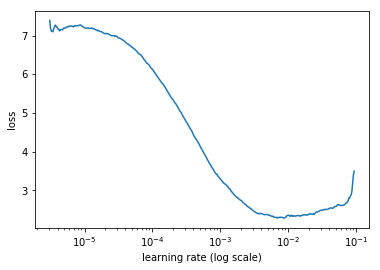

In [233]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)

In [65]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))


 43%|█████████████████████████████▌                                       | 212/494 [13:58<18:35,  3.95s/it, loss=1.86]temp fix
temp fix
100%|████████████████████████████████████████████████████████████████████▊| 493/494 [34:12<00:04,  4.16s/it, loss=1.29]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
epoch      trn_loss   val_loss   
    0      1.287653   1.234192  
 94%|████████████████████████████████████████████████████████████████▊    | 464/494 [32:10<02:04,  4.16s/it, loss=1.02]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    1      0.982678   0.965579  
  2%|█▍                                                                   | 10/494 [00:44<35:38,  4.42s/it, loss=0.961]temp fix
temp fix
 60%|█████████████████████████████████████████                           | 2

    3      0.682589   0.735655  
100%|███████████████████████████████████████████████████████████████████▋| 492/494 [30:06<00:07,  3.67s/it, loss=0.561]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    4      0.57344    0.6894    



[array([0.6894])]

trn_dl stands for training data loader. 
The training data loader is a iterator that returns a mini batch (of size bs)

In [66]:
learn.save('0')

In [67]:
learn.load('0')


In [68]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

In [69]:
b_clas.size(),b_bb.size()

(torch.Size([9, 16, 24]), torch.Size([9, 16, 4]))

In [70]:
idx=7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas

(Variable containing:
  0.0982  0.2500  0.7321  0.7723
 [torch.FloatTensor of size 1x4], Variable containing:
  2
 [torch.LongTensor of size 1])

In [71]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


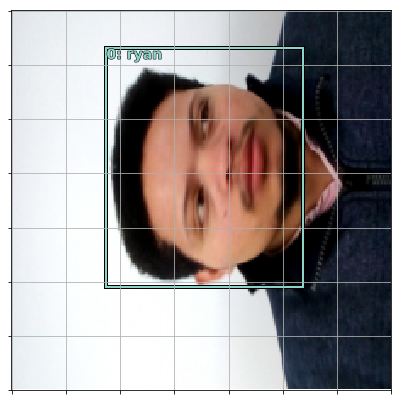

In [72]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


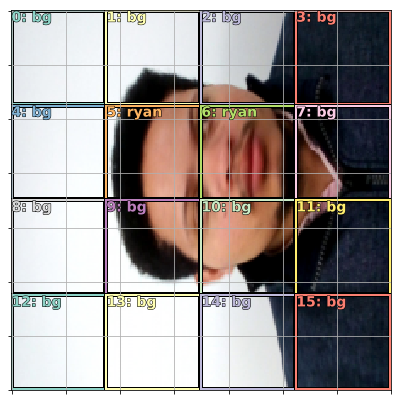

In [73]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [74]:
a_ic = actn_to_bb(b_bboxi, anchors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


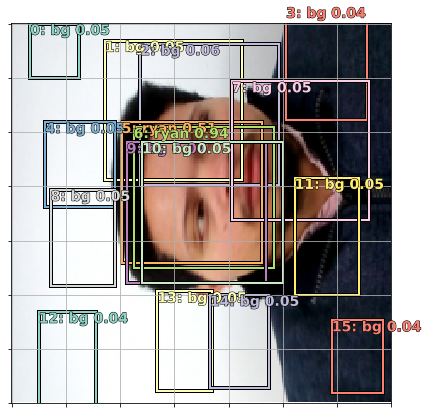

In [75]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)

In [76]:
overlaps = jaccard(bbox.data, anchor_cnr.data)
overlaps



Columns 0 to 9 
 0.0000  0.1067  0.1067  0.0087  0.0000  0.1888  0.1888  0.0144  0.0000  0.1729

Columns 10 to 15 
 0.1729  0.0133  0.0000  0.0000  0.0000  0.0000
[torch.FloatTensor of size 1x16]

In [77]:
overlaps.max(1)

(
  0.1888
 [torch.FloatTensor of size 1], 
  5
 [torch.LongTensor of size 1])

In [78]:
gt_overlap,gt_idx = map_to_ground_truth(overlaps)
gt_overlap,gt_idx

(
  0.0000
  0.1067
  0.1067
  0.0087
  0.0000
  1.9900
  0.1888
  0.0144
  0.0000
  0.1729
  0.1729
  0.0133
  0.0000
  0.0000
  0.0000
  0.0000
 [torch.FloatTensor of size 16], 
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
 [torch.LongTensor of size 16])

In [79]:
gt_clas = clas[gt_idx]; gt_clas

Variable containing:
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
[torch.LongTensor of size 16]

In [80]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(1-pos)[:,0]
pos_idx


 5
[torch.LongTensor of size 1]

In [81]:
gt_clas[1-pos] = len(id2cat)
[id2cat[o] if o<len(id2cat) else 'bg' for o in gt_clas.data]

['bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'ryan',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg']

In [82]:
gt_bbox = bbox[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
clas_loss  = F.cross_entropy(b_clasi, gt_clas)
loc_loss,clas_loss

(Variable containing:
  0.1016
 [torch.FloatTensor of size 1], Variable containing:
  0.3741
 [torch.FloatTensor of size 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


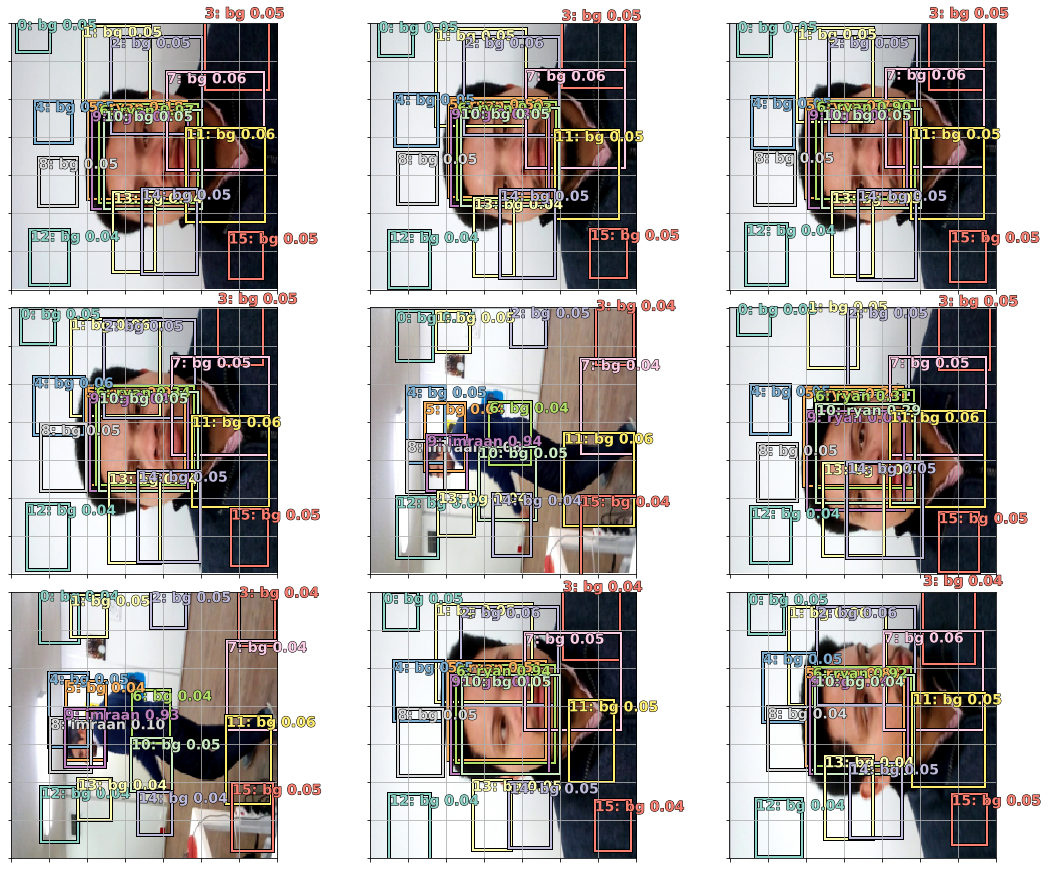

In [83]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(bbox,clas); bbox,clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()

## Creating more anchors

In [84]:
anc_grids = [4,2,1]
# anc_grids = [2]
anc_zooms = [0.7, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

In [85]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [86]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [87]:
anchors

Variable containing:
 0.1250  0.1250  0.1750  0.1750
 0.1250  0.1250  0.1750  0.0875
 0.1250  0.1250  0.0875  0.1750
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.1250  0.2500  0.1250
 0.1250  0.1250  0.1250  0.2500
 0.1250  0.1250  0.3250  0.3250
 0.1250  0.1250  0.3250  0.1625
 0.1250  0.1250  0.1625  0.3250
 0.1250  0.3750  0.1750  0.1750
 0.1250  0.3750  0.1750  0.0875
 0.1250  0.3750  0.0875  0.1750
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.3750  0.2500  0.1250
 0.1250  0.3750  0.1250  0.2500
 0.1250  0.3750  0.3250  0.3250
 0.1250  0.3750  0.3250  0.1625
 0.1250  0.3750  0.1625  0.3250
 0.1250  0.6250  0.1750  0.1750
 0.1250  0.6250  0.1750  0.0875
 0.1250  0.6250  0.0875  0.1750
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.6250  0.2500  0.1250
 0.1250  0.6250  0.1250  0.2500
 0.1250  0.6250  0.3250  0.3250
 0.1250  0.6250  0.3250  0.1625
 0.1250  0.6250  0.1625  0.3250
 0.1250  0.8750  0.1750  0.1750
 0.1250  0.8750  0.1750  0.0875
 0.1250  0.8750  0.0875  0.1750
 0.1250  0.8750  0.

In [88]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

In [89]:
a=np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*224, -1)

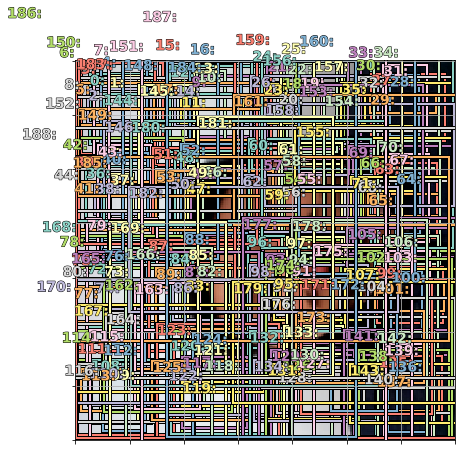

In [90]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

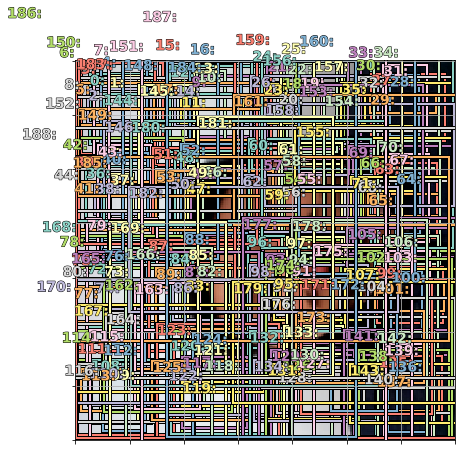

In [91]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

In [92]:
drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [93]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

In [94]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(V(x))

In [95]:
batch[0].size(),batch[1].size()

(torch.Size([9, 189, 24]), torch.Size([9, 189, 4]))

In [96]:
ssd_loss(batch, y, True)


 0.6666
[torch.FloatTensor of size 1]


 0.6948
[torch.FloatTensor of size 1]


 0.7748
[torch.FloatTensor of size 1]


 0.6662
[torch.FloatTensor of size 1]


 0.1949
[torch.FloatTensor of size 1]


 0.6245
[torch.FloatTensor of size 1]


 0.1740
[torch.FloatTensor of size 1]


 0.6165
[torch.FloatTensor of size 1]


 0.7464
[torch.FloatTensor of size 1]

loc: 1.120166301727295, clas: 39.86769104003906


Variable containing:
 40.9879
[torch.FloatTensor of size 1]

In [97]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))

 94%|████████████████████████████████████████████████████████████████▊    | 464/494 [29:18<01:53,  3.79s/it, loss=4.59]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
epoch      trn_loss   val_loss   
    0      4.423707   5.441815  
 93%|███████████████████████████████████████████████████████████████▉     | 458/494 [29:03<02:17,  3.81s/it, loss=3.64]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    1      3.472615   23.53803  
  8%|█████▌                                                                 | 39/494 [02:28<28:53,  3.81s/it, loss=3.4]temp fix
temp fix
 99%|████████████████████████████████████████████████████████████████████▍| 490/494 [31:14<00:15,  3.83s/it, loss=2.79]temp fix
temp fix                                                                             

temp fix                                                                                                               
temp fix
temp fix
temp fix
    3      2.33086    4.438408  



[array([4.43841])]

In [98]:
 learn.save('tmp')

In [99]:
learn.freeze_to(-2)
learn.fit(lrs/2, 1, cycle_len=4, use_clr=(20,8))

 76%|████████████████████████████████████████████████████▌                | 376/494 [41:22<12:59,  6.60s/it, loss=3.39]temp fix
temp fix
 86%|████████████████████████████████████████████████████████████▌         | 427/494 [46:56<07:21,  6.60s/it, loss=3.3]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
epoch      trn_loss   val_loss   
    0      3.036179   39.039026 
 88%|████████████████████████████████████████████████████████████▌        | 434/494 [47:46<06:36,  6.60s/it, loss=2.89]temp fix
temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    1      2.768337   13.770561 
 97%|██████████████████████████████████████████████████████████████████▋  | 477/494 [52:30<01:52,  6.61s/it, loss=2.15]temp fix
temp fix                                                                    

    3      1.727231   12.04593  



[array([12.04593])]

In [100]:
learn.save('prefocal')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


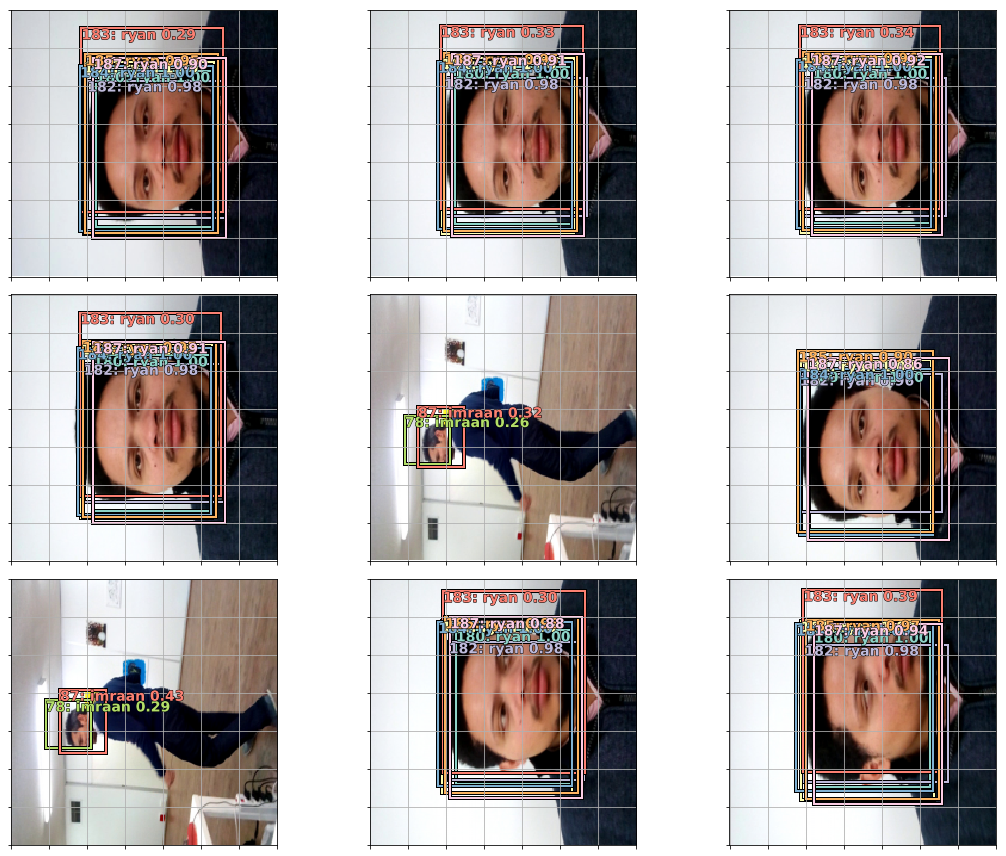

In [101]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.21)
plt.tight_layout()

In [102]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

In [103]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

In [104]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(x)
ssd_loss(batch, y, True)


 0.6666
[torch.FloatTensor of size 1]


 0.6948
[torch.FloatTensor of size 1]


 0.7748
[torch.FloatTensor of size 1]


 0.6662
[torch.FloatTensor of size 1]


 0.1949
[torch.FloatTensor of size 1]


 0.6245
[torch.FloatTensor of size 1]


 0.1740
[torch.FloatTensor of size 1]


 0.6165
[torch.FloatTensor of size 1]


 0.7464
[torch.FloatTensor of size 1]

loc: 0.2838035821914673, clas: 0.29963693022727966


Variable containing:
 0.5834
[torch.FloatTensor of size 1]

In [105]:
learn.fit(lrs, 1, cycle_len=10, use_clr=(20,10))

 77%|████████████████████████████████████████████████████▊                | 378/494 [41:40<12:47,  6.61s/it, loss=1.07]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
epoch      trn_loss   val_loss   
    0      1.304432   1.389977  
 97%|██████████████████████████████████████████████████████████████████▊  | 478/494 [52:39<01:45,  6.61s/it, loss=1.12]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    1      1.198915   1.505143  
 95%|█████████████████████████████████████████████████████████████████▊   | 471/494 [51:51<02:31,  6.61s/it, loss=1.15]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    2      1.173239   2.260447  
  1%|▌                                    

temp fix                                                                                                               
temp fix
temp fix
temp fix
    3      1.112035   66.855361 
 82%|███████████████████████████████████████████████████████▉            | 406/494 [44:51<09:43,  6.63s/it, loss=0.907]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    4      0.849566   18.320057 
 97%|█████████████████████████████████████████████████████████████████▋  | 477/494 [54:40<01:56,  6.88s/it, loss=0.886]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    5      1.095519   1.591513  
 99%|███████████████████████████████████████████████████████████████████▌| 491/494 [56:21<00:20,  6.89s/it, loss=0.891]temp fix
temp fix                                                                    

 97%|██████████████████████████████████████████████████████████████████  | 480/494 [55:27<01:37,  6.93s/it, loss=0.751]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    7      0.767952   0.661259  
 98%|██████████████████████████████████████████████████████████████████▉ | 486/494 [56:04<00:55,  6.92s/it, loss=0.652]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    8      0.639123   0.587645  
 99%|███████████████████████████████████████████████████████████████████▌| 491/494 [55:35<00:20,  6.79s/it, loss=0.606]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    9      0.605887   0.555968  



[array([0.55597])]

In [106]:
learn.save('fl0')

In [107]:
learn.load('fl0')

In [108]:
learn.freeze_to(-2)
learn.fit(lrs/4, 1, cycle_len=10, use_clr=(20,10))

 87%|███████████████████████████████████████████████████████████▎        | 431/494 [49:17<07:12,  6.86s/it, loss=0.643]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
epoch      trn_loss   val_loss   
    0      0.652534   0.647271  
 91%|██████████████████████████████████████████████████████████████▏     | 452/494 [51:47<04:48,  6.88s/it, loss=0.619]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    1      0.632681   1.087546  
 99%|██████████████████████████████████████████████████████████████████▌| 491/494 [1:04:49<00:23,  7.92s/it, loss=0.63]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    2      0.633446   0.619702  
 79%|█████████████████████████████████████

 84%|████████████████████████████████████████████████████████▊           | 413/494 [52:54<10:22,  7.69s/it, loss=0.596]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    3      0.593202   2.615354  
 94%|█████████████████████████████████████████████████████████████▋    | 462/494 [1:05:57<04:34,  8.57s/it, loss=0.547]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    4      0.542792   0.949949  
 98%|████████████████████████████████████████████████████████████████▌ | 483/494 [1:04:19<01:27,  7.99s/it, loss=0.517]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    5      0.512395   0.683976  
 96%|█████████████████████████████████████████████████████████████████▌  | 4

100%|███████████████████████████████████████████████████████████████████▋| 492/494 [57:45<00:14,  7.04s/it, loss=0.489]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    7      0.492889   0.486896  
 94%|████████████████████████████████████████████████████████████████▌    | 462/494 [54:18<03:45,  7.05s/it, loss=0.47]temp fix
temp fix                                                                                                               
temp fix
temp fix
temp fix
    8      0.457343   0.552309  
 84%|████████████████████████████████████████████████████████▊           | 413/494 [49:10<09:38,  7.14s/it, loss=0.455]temp fix
temp fix
 90%|█████████████████████████████████████████████████████████████▎      | 445/494 [52:58<05:49,  7.14s/it, loss=0.452]temp fix
temp fix                                                                                                               

[array([0.45958])]

In [109]:
learn.save('drop4')

In [110]:
learn.load('drop4')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 9 is out of bounds for axis 0 with size 9

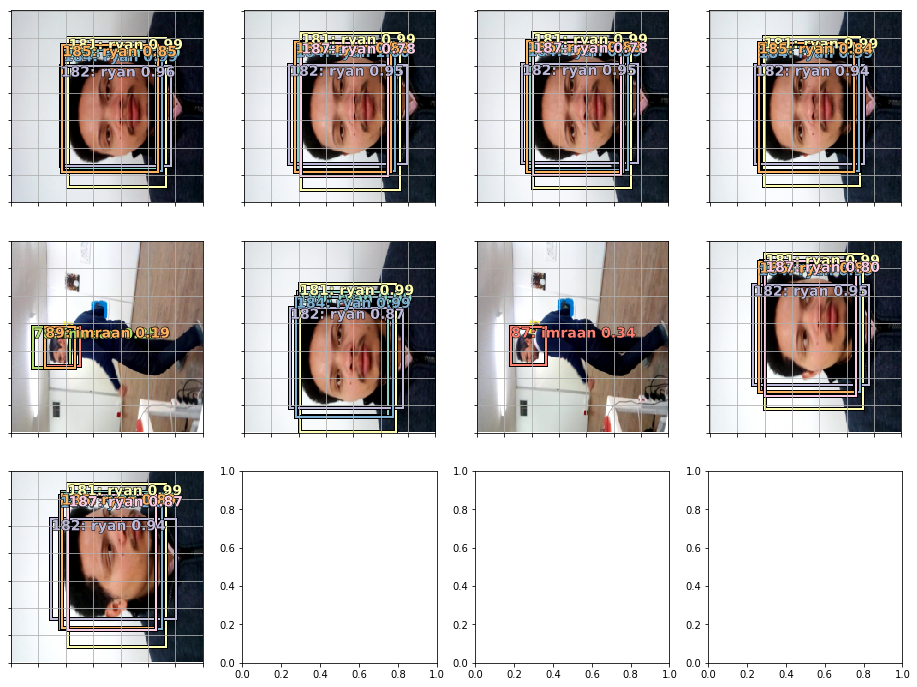

In [122]:
plot_results(0.75)

## Non Maximum Surprission

In [112]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [132]:
#x,y = next(iter(md.val_dl))
x,y = next(iter(md.trn_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

In [133]:
def show_nmf(idx):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > 0.25
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, ax = plt.subplots(figsize=(8,8))
    torch_gt(ax, ima, out2, cc, out1, 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


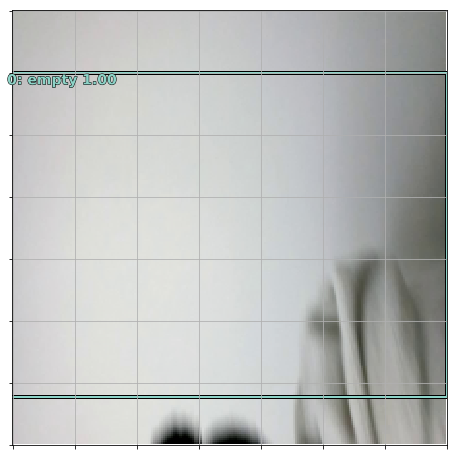

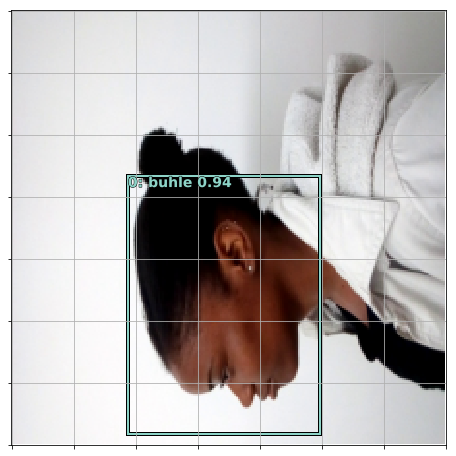

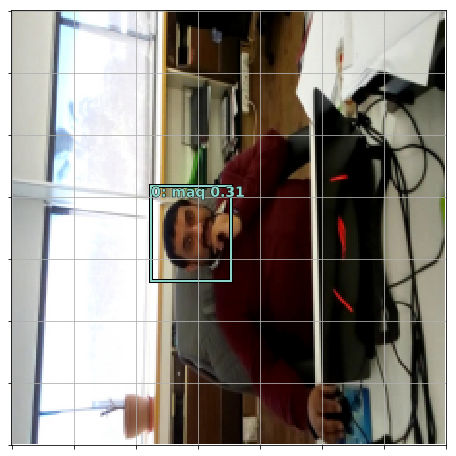

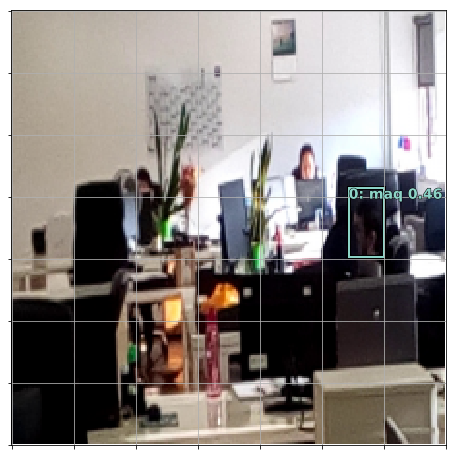

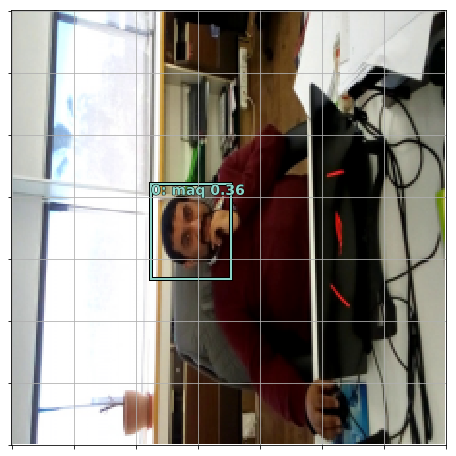

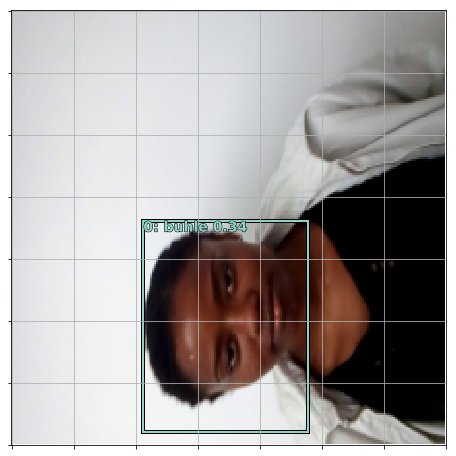

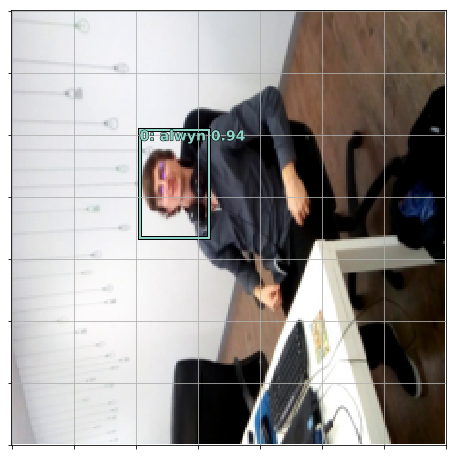

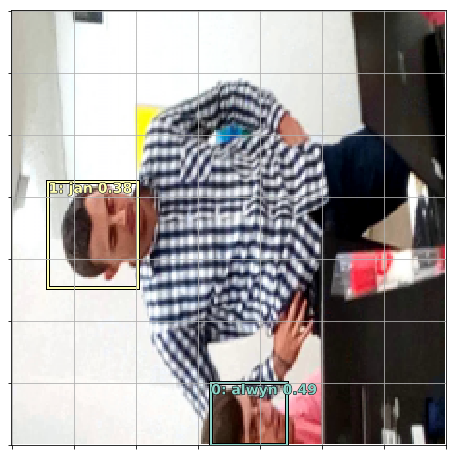

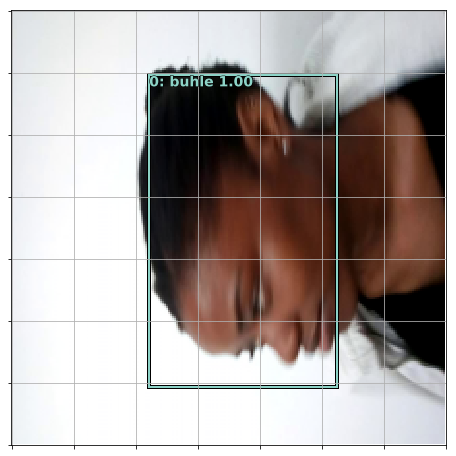

In [134]:
for i in range(9): show_nmf(i)

In [ ]:
2+2